### Simple COVID-19 stochastic model based on Anderson et al. (2020)

Below I define a stochastic version of the model defined diagrammatically below taken from [Anderson et al. (2020)](https://www.thelancet.com/journals/lancet/article/PIIS0140-6736(20)30567-5/fulltext).

<img src="diagram-from-Anderson2020.png" width="600"/>

Note that in the epidemology of an SEIR model, the formalism usually indicates that, in this case, $\lambda = \beta  (q_1I_1+I^{\rm mild}_2+I^{\rm mild}_3+bq_2I^{\rm severe}_2+bq_3I^{\rm severe}_3 + mq_2Y_2 + mq_3Y_3 + gE)/N_{\rm tot}$. First the following imports are necessary...

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

Then the model parameters (all in units of 1/day) and initial compartment numbers must be defined (taken from SI3 of [Anderson et al. (2020)](https://www.thelancet.com/journals/lancet/article/PIIS0140-6736(20)30567-5/fulltext))...

In [2]:
b,bet,m,g,sig,gam1,gam2,gam3,alph,p,q1,q2,q3 = 1.0,0.124,1.0,0.0,1.0/2.42,1.0/2.42,0.1,0.1,0.195,0.33,1.0,0.64,0.64
S,E,I1,I2mild,I2severe,I3mild,I3severe,Y2,Y3,R = 9995,5,0,0,0,0,0,0,0,0

Finally, the number of realisations and the number of days to run must be chosen...

In [3]:
nreals = 100
ndays = 250

The model is coded in the following function...

In [10]:
# Package parameters and initial conditions all together
params = [b, bet, m, g, sig, gam1, gam2, gam3, alph, p, q1, q2, q3]
initconds = [S*np.ones(nreals),E*np.ones(nreals), I1*np.ones(nreals), I2mild*np.ones(nreals),\
             I2severe*np.ones(nreals), I3mild*np.ones(nreals), I3severe*np.ones(nreals), Y2*np.ones(nreals),\
             Y3*np.ones(nreals), R*np.ones(nreals)]
# Define model function to output after specified time period
def covid_simple(initconds,params,reals,runtime,output_to_file): 
    # Open storage for output to file
    f = open(output_to_file, "w")
    # Unpack parameters and initial conditions
    [b, bet, m, g, sig, gam1, gam2, gam3, alph, p, q1, q2, q3] = params
    [S, E, I1, I2mild, I2severe, I3mild, I3severe, Y2, Y3, R] = initconds 
    # Convert to float because I'm like that...
    runtime = float(runtime)   
    # Compute total population number for each realisation
    Ntot = S+E+I1+I2mild+I2severe+I3mild+I3severe+Y2+Y3+R
    # Main loop
    t = np.zeros(reals)
    terminated = np.ones(reals)
    while np.any(t < runtime):
        # Terminate loop if everyone has recovered
        if np.all(S+E+I1+I2mild+I2severe+I3mild+I3severe+Y2+Y3) == 0: break
        # Update the event rates
        rate_S_E = bet*(q1*I1+I2mild+b*q2*I2severe+I3mild+b*q3*I3severe+m*q2*Y2+m*q3*Y3+g*E)*S/Ntot 
        rate_E_I1, rate_I1_I2, rate_I2severe_Y2 = sig*E, gam1*I1, alph*I2severe
        rate_I2mild_I3mild, rate_I2severe_I3severe, rate_Y2_Y3 = gam2*I2mild, gam2*I2severe, gam2*Y2
        rate_I3mild_R, rate_I3severe_R, rate_Y3_R = gam3*I3mild, gam3*I3severe, gam3*Y3       
        # Sum the rates
        rate_sum = rate_S_E + rate_E_I1 + rate_I1_I2 + rate_I2severe_Y2 + rate_I2mild_I3mild + \
                   rate_I2severe_I3severe + rate_Y2_Y3 + rate_I3mild_R + rate_I3severe_R + rate_Y3_R
        # Avoid pathologies at the end
        rate_sum[rate_sum<=0.0] = 1.0
        # Take step forward in time and determine when to stop each run
        t = t + terminated*np.random.exponential(1.0/rate_sum,size=reals) 
        terminated = (t<runtime)
        # Choose the event to occur in each realisation
        severe = np.random.binomial(1,p,size=reals)
        event = np.random.uniform(size=reals)
        event_probs = np.asarray([rate_S_E/rate_sum,rate_E_I1/rate_sum,\
                                  rate_I1_I2/rate_sum,rate_I2severe_Y2/rate_sum,rate_I2mild_I3mild/rate_sum,\
                                  rate_I2severe_I3severe/rate_sum,rate_Y2_Y3/rate_sum,rate_I3mild_R/rate_sum,\
                                  rate_I3severe_R/rate_sum,rate_Y3_R/rate_sum])
        cumul_probs = np.cumsum(event_probs,axis=0)
        # S -> E
        S = S - terminated*(event<cumul_probs[0])
        # S -> E, E -> I1
        E = E + terminated*(event<cumul_probs[0]) - terminated*(cumul_probs[1]>event)*(event>=cumul_probs[0])
        # E -> I1, I1 -> I2
        I1 = I1 + terminated*(cumul_probs[1]>event)*(event>=cumul_probs[0]) \
                - terminated*(cumul_probs[2]>event)*(event>=cumul_probs[1])
        # I1 -> I2mild, I2mild -> I3mild
        I2mild = I2mild + terminated*(severe==0)*(cumul_probs[2]>event)*(event>=cumul_probs[1]) \
                        - terminated*(cumul_probs[4]>event)*(event>=cumul_probs[3])
        # I1 -> I2severe, I2severe -> Y2, I2severe -> I3severe
        I2severe = I2severe + terminated*(severe==1)*(cumul_probs[2]>event)*(event>=cumul_probs[1]) \
                            - terminated*(cumul_probs[3]>event)*(event>=cumul_probs[2]) \
                            - terminated*(cumul_probs[5]>event)*(event>=cumul_probs[4])
        # I2mild -> I3mild, I3mild -> R
        I3mild = I3mild + terminated*(cumul_probs[4]>event)*(event>=cumul_probs[3]) \
                        - terminated*(cumul_probs[7]>event)*(event>=cumul_probs[6])
        # I2severe -> I3severe, I3severe -> R
        I3severe = I3severe + terminated*(cumul_probs[5]>event)*(event>=cumul_probs[4]) \
                            - terminated*(cumul_probs[8]>event)*(event>=cumul_probs[7])
        # I2severe -> Y2, Y2 -> Y3
        Y2 = Y2 + terminated*(cumul_probs[3]>event)*(event>=cumul_probs[2]) \
                - terminated*(cumul_probs[6]>event)*(event>=cumul_probs[5])
        # Y2 -> Y3, Y3 -> R
        Y3 = Y3 + terminated*(cumul_probs[6]>event)*(event>=cumul_probs[5]) \
                - terminated*(cumul_probs[9]>event)*(event>=cumul_probs[8])
        # I3mild -> R, I3severe -> R, Y3 -> R
        R = R + terminated*(cumul_probs[7]>event)*(event>=cumul_probs[6]) \
              + terminated*(cumul_probs[8]>event)*(event>=cumul_probs[7]) \
              + terminated*(cumul_probs[9]>event)*(event>=cumul_probs[8])
        # Store values in file
        f.write(','.join(map(str,np.concatenate([t, S, E, I1, I2mild, I2severe, \
                                                 I3mild, I3severe, Y2, Y3, R]).ravel().tolist()))+'\n')
        f.flush()
    # Close file
    f.close()
    # Setup output column name list
    column_names = []
    for l in ['t', 'S', 'E', 'Ii', 'Iiimild', 'Iiisevere', 'Iiiimild', 'Iiiisevere', 'Yii', 'Yiii', 'R']:
        for r in range(0,nreals):
            column_names.append(l+'_'+str(r))
    # Load dataframe with column names
    df = pd.read_csv(output_to_file,names=column_names)
    # Create dictionary of sub dataframes from output for each time series realisation
    dict_of_dfs = {}
    for r in range(0,nreals):
        dict_of_dfs['real_'+str(r)] = df[['t_'+str(r), 'S_'+str(r), 'E_'+str(r), 'Ii_'+str(r),\
                                          'Iiimild_'+str(r), 'Iiisevere_'+str(r), 'Iiiimild_'+str(r),\
                                          'Iiiisevere_'+str(r), 'Yii_'+str(r), 'Yiii_'+str(r), 'R_'+str(r)]]
        # Strip the time column of its number for merging
        dict_of_dfs['real_'+str(r)].columns = dict_of_dfs['real_'+str(r)].columns.str.rstrip('_'+str(r))
    # Output resulting compartment numbers to a dictionary of pandas dataframes
    return dict_of_dfs

Let's run the code and create a time-merged dataframe with all of the realisations and compartments as columns...

In [11]:
# Run code and obtain dictionary of dataframes output
ddf = covid_simple(initconds,params,nreals,ndays,'plot_data/non-lockdown.csv')
# Map all column names onto their realisation numbers (apart from time) to avoid merge clashes
merged_df = ddf['real_0']
merged_df.columns = merged_df.columns.map(lambda c: c+'_0' if c!='t' else c)
for r in range(1,nreals):
    ddf['real_'+str(r)].columns = ddf['real_'+str(r)].columns.map(lambda c: c+'_'+str(r) if c!='t' else c)
    merged_df = pd.merge_asof(merged_df,ddf['real_'+str(r)],on='t')
# Set index to time
merged_df = merged_df.set_index('t')
merged_df

,S_0,E_0,Ii_0,Iiimild_0,Iiisevere_0,Iiiimild_0,Iiiisevere_0,Yii_0,Yiii_0,R_0,...,S_99,E_99,Ii_99,Iiimild_99,Iiisevere_99,Iiiimild_99,Iiiisevere_99,Yii_99,Yiii_99,R_99
t,,,,,,,,,,,,,,,,,,,,,
0.095864,9995.0,4.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,9995.0,4.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0.246975,9995.0,4.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,9995.0,4.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0.418286,9995.0,3.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,9995.0,4.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0.437790,9995.0,2.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,9995.0,4.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1.191470,9995.0,2.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,...,9995.0,3.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
250.328073,1090.0,1.0,1.0,1.0,0.0,7.0,0.0,0.0,5.0,8895.0,...,1200.0,2.0,2.0,14.0,2.0,29.0,4.0,9.0,18.0,8720.0
250.328073,1090.0,1.0,1.0,1.0,0.0,7.0,0.0,0.0,5.0,8895.0,...,1200.0,2.0,2.0,14.0,2.0,29.0,4.0,9.0,18.0,8720.0
250.328073,1090.0,1.0,1.0,1.0,0.0,7.0,0.0,0.0,5.0,8895.0,...,1200.0,2.0,2.0,14.0,2.0,29.0,4.0,9.0,18.0,8720.0


Let's first plot the mean and 95% credible region for each compartment...

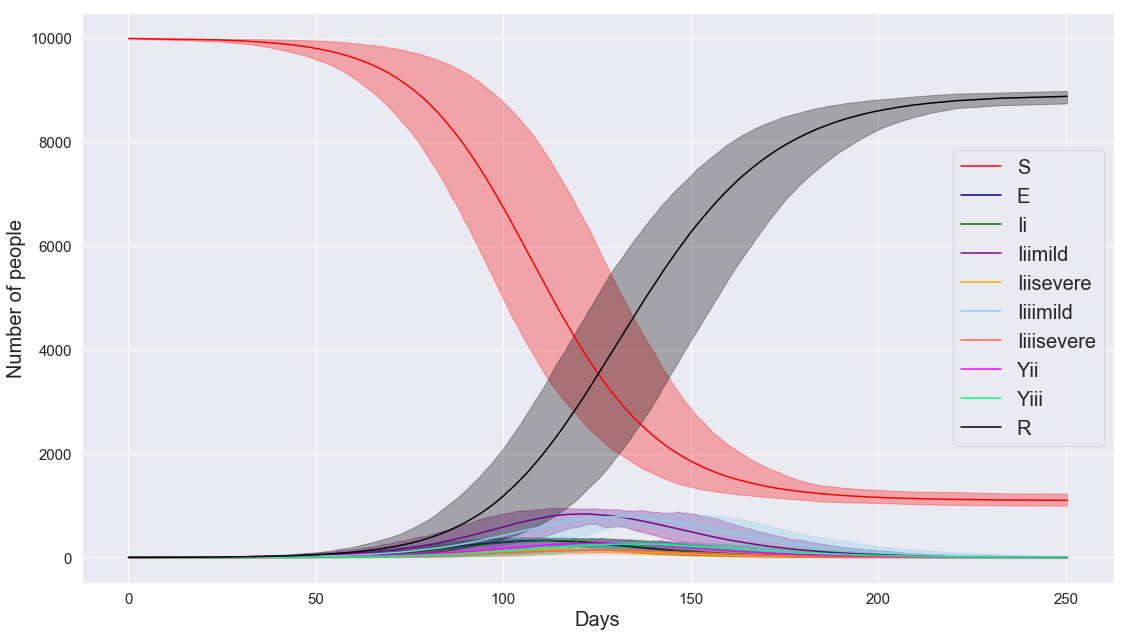

In [12]:
# The number of points to skip per value to make plotting faster
plot_every_n = 100
# Loop over all compartments of the model and plot on the same axes
for lab, col in zip(['S', 'E', 'Ii', 'Iiimild', 'Iiisevere', 'Iiiimild', 'Iiiisevere', 'Yii', 'Yiii', 'R'],
       ['red','darkblue','darkgreen','purple','orange','skyblue','tomato','magenta','springgreen','black']):
    # Compute mean and credible limits
    df = merged_df[[lab+'_'+str(r) for r in range(0,nreals)]]
    df_mean = df.iloc[::plot_every_n, :].mean(axis=1)
    df_lowerCL = df.iloc[::plot_every_n, :].quantile(0.025,axis=1)
    df_upperCL = df.iloc[::plot_every_n, :].quantile(0.975,axis=1)
    # Plot the mean and credible limits in each case
    plt.plot(merged_df.index[::plot_every_n],df_mean.values,color=col,label=lab)
    plt.fill_between(merged_df.index[::plot_every_n],df_lowerCL.values,df_upperCL.values,color=col,alpha=0.3)
# Name axes and rescale plot 
axes = plt.gca()
axes.set_ylabel('Number of people',fontsize=20)
axes.set_xlabel('Days',fontsize=20)
axes.tick_params(labelsize=15)
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.legend(fontsize=20)
plt.show()

### Plotting the effective reproduction number and epidemic growth rate

We need to do a little bit of linear algebra to compute the basic reproduction number $R_0$ of the system. At the disease-free equilibrium, $S=N_{\rm tot}$ and all other compartments vanish, hence, using the vector space of infected compartments $(E,I_1,I_2^{\rm mild},I_2^{\rm severe},I_3^{\rm mild},I_3^{\rm severe},Y_2,Y_3)^{\rm T}$, the next-generation matrix (see here: https://en.wikipedia.org/wiki/Next-generation_matrix) for the above model is pretty trivial

$$F=(\lambda S,0,0,0,0,0,0,0)^{\rm T}$$

$$V=[\sigma E,\gamma_1I_1-\sigma E,\gamma_2 I^{\rm mild}_2-\gamma_1(1-p)I_1,(\gamma_2+\alpha )I^{\rm severe}_2-\gamma_1pI_1,\gamma_3I_3^{\rm mild}-\gamma_2I^{\rm mild}_2,\gamma_3I^{\rm severe}_3-\gamma_2I_2^{\rm severe},\gamma_2Y_2-\alpha I^{\rm severe}_2,\gamma_3Y_3-\gamma_2Y_2]^{\rm T}$$

$${\cal J}(F) = \begin{pmatrix} \beta g & \beta q_1 & \beta & \beta b q_2  & \beta  & \beta b q_3 & \beta m q_2 &  \beta m q_3 \\ 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\ 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\ 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\ 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\ 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\ 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\ 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \end{pmatrix}$$ 

$${\cal J}(V) = \begin{pmatrix} \sigma  & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\ -\sigma & \gamma_1 & 0 & 0 & 0 & 0 & 0 & 0 \\ 0 & -\gamma_1(1-p) & \gamma_2 & 0 & 0 & 0 & 0 & 0 \\ 0 & -\gamma_1p & 0 & \gamma_2+\alpha & 0 & 0 & 0 & 0 \\ 0 & 0 & -\gamma_2 & 0 & \gamma_3 & 0 & 0 & 0 \\ 0 & 0 & 0 & -\gamma_2 & 0 & \gamma_3 & 0 & 0 \\ 0 & 0 & 0 & -\alpha & 0 & 0 & \gamma_2 & 0 \\ 0 & 0 & 0 & 0 & 0 & 0 & -\gamma_2 & \gamma_3 \end{pmatrix}$$

$$\Longrightarrow {\rm NGM} =  {\cal J}(F){\cal J}(V)^{-1} \Longrightarrow \rho ({\rm NGM}) = R_0 = \frac{\beta g}{\sigma} + \frac{\beta q_1}{\gamma_1} + \frac{\beta (1-p)}{\gamma_2} + \frac{\beta b q_2 p}{\alpha + \gamma_2} + \frac{\beta (1-p)}{\gamma_3} + \frac{\beta b q_3 \gamma_2p}{(\alpha + \gamma_2)\gamma_3} + \frac{\beta m q_2 \alpha p}{(\alpha + \gamma_2)\gamma_2} + \frac{\beta m q_3 \alpha p}{(\alpha + \gamma_2)\gamma_3}\,,$$

where $\rho (\cdot )$ just denotes the spectral radius. The effective reproduction number $R_t$ at time $t$ in this model is simply $R_t = R_0 (S/N_{\rm tot})$ and the epidemic growth rate $r_t$ is numerically calculable from $r_t = \delta \ln (I_1+I^{\rm mild}_2+I^{\rm severe}_2+I^{\rm mild}_3+I^{\rm severe}_3+Y_2+Y_3) / \delta t$, hence, the output data can also be plotted to give these values...

/usr/local/lib/python3.7/site-packages/numpy/lib/function_base.py:1061: RuntimeWarning: invalid value encountered in true_divide
  a = -(dx2)/(dx1 * (dx1 + dx2))
/usr/local/lib/python3.7/site-packages/numpy/lib/function_base.py:1062: RuntimeWarning: divide by zero encountered in true_divide
  b = (dx2 - dx1) / (dx1 * dx2)
/usr/local/lib/python3.7/site-packages/numpy/lib/function_base.py:1062: RuntimeWarning: invalid value encountered in true_divide
  b = (dx2 - dx1) / (dx1 * dx2)
/usr/local/lib/python3.7/site-packages/numpy/lib/function_base.py:1063: RuntimeWarning: divide by zero encountered in true_divide
  c = dx1 / (dx2 * (dx1 + dx2))
/usr/local/lib/python3.7/site-packages/numpy/lib/function_base.py:1063: RuntimeWarning: invalid value encountered in true_divide
  c = dx1 / (dx2 * (dx1 + dx2))
/usr/local/lib/python3.7/site-packages/numpy/lib/function_base.py:1069: RuntimeWarning: invalid value encountered in add
  out[tuple(slice1)] = a * f[tuple(slice2)] + b * f[tuple(slice3)] + c 

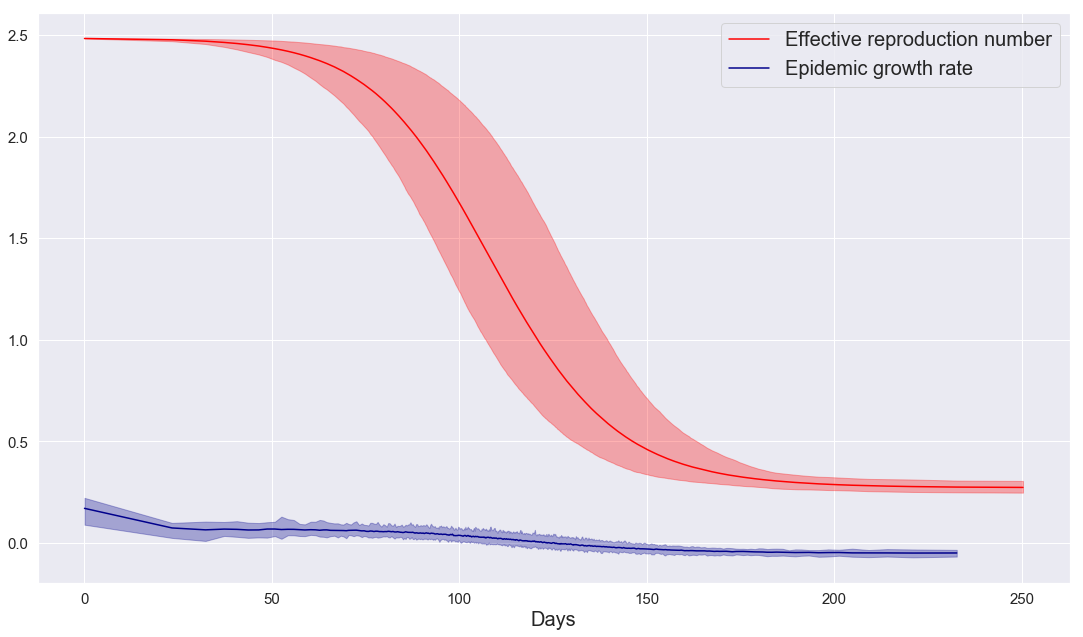

In [13]:
# The number of points to skip per value to make plotting faster
plot_every_n = 100
# Order of centred finite difference used to compute the epidemic growth rate (can be 1 or 2)
order_grad = 2
# Pull out values from merged dataframe
S_df = merged_df[['S_'+str(r) for r in range(0,nreals)]]
E_df = merged_df[['E_'+str(r) for r in range(0,nreals)]]
Ii_df = merged_df[['Ii_'+str(r) for r in range(0,nreals)]]
Iiimild_df = merged_df[['Iiimild_'+str(r) for r in range(0,nreals)]]
Iiisevere_df = merged_df[['Iiisevere_'+str(r) for r in range(0,nreals)]]
Iiiimild_df = merged_df[['Iiiimild_'+str(r) for r in range(0,nreals)]]
Iiiisevere_df = merged_df[['Iiiisevere_'+str(r) for r in range(0,nreals)]]
Yii_df = merged_df[['Yii_'+str(r) for r in range(0,nreals)]]
Yiii_df = merged_df[['Yiii_'+str(r) for r in range(0,nreals)]]
R_df = merged_df[['R_'+str(r) for r in range(0,nreals)]]
# Compute the total infected, the basic and effective reproduction numbers and epidemic growth rate
times = Ii_df.iloc[::plot_every_n, :].index
totpop = S_df.iloc[0,0]+E_df.iloc[0,0]+Ii_df.iloc[0,0]+Iiimild_df.iloc[0,0]+Iiisevere_df.iloc[0,0]+\
         Iiiimild_df.iloc[0,0]+Iiiisevere_df.iloc[0,0]+Yii_df.iloc[0,0]+Yiii_df.iloc[0,0]+R_df.iloc[0,0]
totinf = Ii_df.iloc[::plot_every_n, :].values+Iiimild_df.iloc[::plot_every_n, :].values+\
         Iiisevere_df.iloc[::plot_every_n, :].values+Iiiimild_df.iloc[::plot_every_n, :].values+\
         Iiiisevere_df.iloc[::plot_every_n, :].values+Yii_df.iloc[::plot_every_n, :].values+\
         Yiii_df.iloc[::plot_every_n, :].values
brn = (bet*g/sig) + (bet*q1/gam1) + (bet*(1.0-p)/gam2) + (bet*b*q2*p/(alph+gam2)) + (bet*(1.0-p)/gam3)+\
      (bet*b*q3*gam2*p/(gam3*(alph+gam2))) + (bet*m*q2*alph*p/(gam2*(alph+gam2)))+(bet*m*q3*alph*p/(gam3*(alph+gam2)))
ern = brn*(S_df.iloc[::plot_every_n, :].values/totpop)
egr = np.gradient(np.log(totinf),times,axis=0,edge_order=order_grad)
# Compute mean and credible limits of the effective reproduction number and epidemic growth rate  
ern_mean = np.nanmean(ern,axis=1)
ern_lowerCL = np.nanquantile(ern,0.025,axis=1)
ern_upperCL = np.nanquantile(ern,0.975,axis=1)
egr_mean = np.nanmean(egr,axis=1)
egr_lowerCL = np.nanquantile(egr,0.025,axis=1)
egr_upperCL = np.nanquantile(egr,0.975,axis=1)
# Plot the mean and credible limits in each case
plt.plot(times,ern_mean,color='red',label='Effective reproduction number')
plt.fill_between(times,ern_lowerCL,ern_upperCL,color='red',alpha=0.3)
plt.plot(times,egr_mean,color='darkblue',label='Epidemic growth rate')
plt.fill_between(times,egr_lowerCL,egr_upperCL,color='darkblue',alpha=0.3)
# Name axes and rescale plot 
axes = plt.gca()
axes.set_xlabel('Days',fontsize=20)
axes.tick_params(labelsize=15)
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.legend(fontsize=20)
plt.show()

In addition, the standard epidemic curve (number of new cases per day) looks like this...

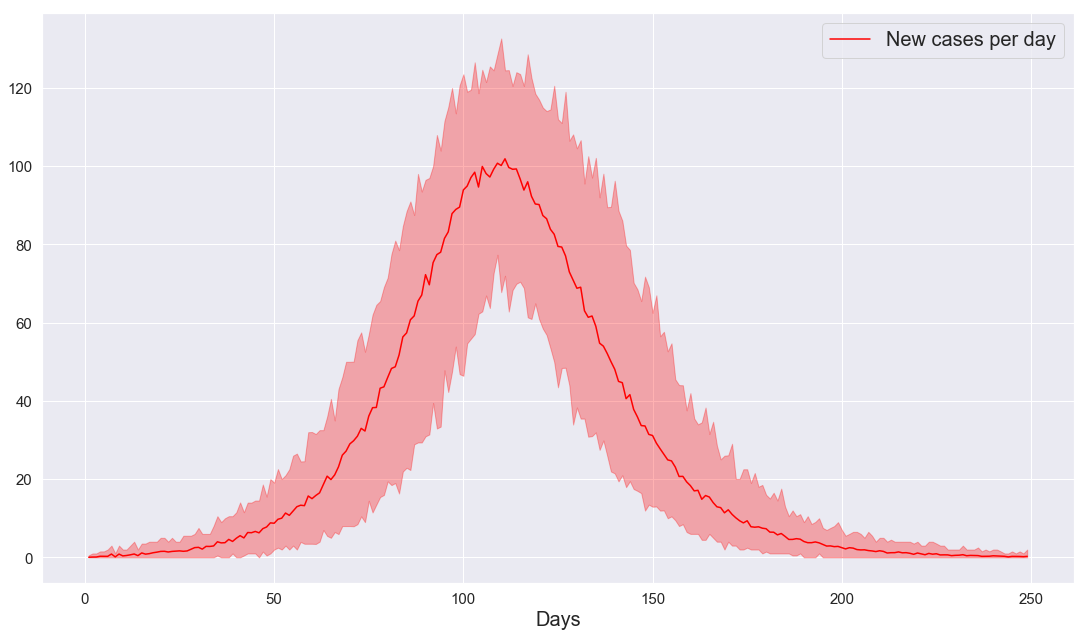

In [14]:
# New cases per day calculation
DE_df = E_df.diff()
DE_df[DE_df<0.0] = 0.0
ncpd_df = DE_df.groupby(pd.cut(E_df.index, np.arange(0, ndays, 1))).sum()
# Compute mean and credible limits of the effective reproduction number and epidemic growth rate  
ncpd_mean = ncpd_df.mean(axis=1)
ncpd_lowerCL = ncpd_df.quantile(0.025,axis=1)
ncpd_upperCL = ncpd_df.quantile(0.975,axis=1)
# Plot the mean and credible limits in each case
plt.plot(np.arange(1, ndays, 1),ncpd_mean,color='red',label='New cases per day')
plt.fill_between(np.arange(1, ndays, 1),ncpd_lowerCL,ncpd_upperCL,color='red',alpha=0.3)
# Name axes and rescale plot 
axes = plt.gca()
axes.set_xlabel('Days',fontsize=20)
axes.tick_params(labelsize=15)
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.legend(fontsize=20)
plt.show()

### Using the simulation to mimic lockdown for a specified number of days

By running successive simulations we can also mimic the lockdown process over a specified number of days, which we define as:
1. From day 1-82 before lockdown no voluntary or mandatory isolation ($b=1$, $m=1$).
2. From the start of lockdown on day 83 to the end of the simulation voluntary and mandatory isolation are in place ($b=0.08$, $m=0.01$).
3. The first phase of lockdown lasts from day 83 - day 132 and the lockdown effect on $\beta$ is $0.48\beta$.
4. The second phase of lockdown lasts from day 133 - day 163 and the lockdown effect on $\beta$ is $0.36\beta$.
5. The third phase of lockdown lasts from day 164 - day 186 and the lockdown effect on $\beta$ is $0.28\beta$.
6. Lockdown is lifted on day 187 but $\beta$ does not go back to its pre-lockdown value; the reduction is a factor of $0.7\beta$ (in addition to voluntary and mandatory isolation being in place, i.e. b=0.8 and m=0.01).
7. Finally, we will stop the simulation on day 289.

In [16]:
# Number of days to run pre-lockdown
ndays_to_lockdown = 83
# Number of days to run during first phase of lockdown
ndays_during_flockdown = 49
# Number of days to run during second phase of lockdown
ndays_during_slockdown = 31
# Number of days to run during third phase of lockdown
ndays_during_tlockdown = 23
# Number of days to run post-lockdown
ndays_beyond_lockdown = 103
# Pre-lockdown parameters and initial conditions
b,bet,m,g,sig,gam1,gam2,gam3,alph,p,q1,q2,q3 = 1.0,0.124,1.0,0.0,1.0/2.42,1.0/2.42,0.1,0.1,0.195,0.33,1.0,0.64,0.64
S,E,I1,I2mild,I2severe,I3mild,I3severe,Y2,Y3,R = 9995,5,0,0,0,0,0,0,0,0
# Package parameters and initial conditions all together
params_pre = [b, bet, m, g, sig, gam1, gam2, gam3, alph, p, q1, q2, q3]
initconds_pre = [S*np.ones(nreals),E*np.ones(nreals), I1*np.ones(nreals), I2mild*np.ones(nreals),\
                 I2severe*np.ones(nreals), I3mild*np.ones(nreals), I3severe*np.ones(nreals), Y2*np.ones(nreals),\
                 Y3*np.ones(nreals), R*np.ones(nreals)]
# Run pre-lockdown pandemic
ddf_pre = covid_simple(initconds_pre,params_pre,nreals,ndays_to_lockdown,'plot_data/pre-lockdown.csv')
# FIRST PHASE
# Map all column names onto their realisation numbers (apart from time) to avoid merge clashes
merged_df_pre = ddf_pre['real_0']
merged_df_pre.columns = merged_df_pre.columns.map(lambda c: c+'_0' if c!='t' else c)
for r in range(1,nreals):
    ddf_pre['real_'+str(r)].columns = ddf_pre['real_'+str(r)].columns.map(lambda c: c+'_'+str(r) if c!='t' else c)
    merged_df_pre = pd.merge_asof(merged_df_pre,ddf_pre['real_'+str(r)],on='t')
# Set index to time
merged_df_pre = merged_df_pre.set_index('t')
# Pull out values from merged pre-lockdown dataframe
S_df_pre = merged_df_pre[['S_'+str(r) for r in range(0,nreals)]]
E_df_pre = merged_df_pre[['E_'+str(r) for r in range(0,nreals)]]
Ii_df_pre = merged_df_pre[['Ii_'+str(r) for r in range(0,nreals)]]
Iiimild_df_pre = merged_df_pre[['Iiimild_'+str(r) for r in range(0,nreals)]]
Iiisevere_df_pre = merged_df_pre[['Iiisevere_'+str(r) for r in range(0,nreals)]]
Iiiimild_df_pre = merged_df_pre[['Iiiimild_'+str(r) for r in range(0,nreals)]]
Iiiisevere_df_pre = merged_df_pre[['Iiiisevere_'+str(r) for r in range(0,nreals)]]
Yii_df_pre = merged_df_pre[['Yii_'+str(r) for r in range(0,nreals)]]
Yiii_df_pre = merged_df_pre[['Yiii_'+str(r) for r in range(0,nreals)]]
R_df_pre = merged_df_pre[['R_'+str(r) for r in range(0,nreals)]]
# Update the parameters and initial conditions for the first lockdown runs
b,bet,m,g,sig,gam1,gam2,gam3,alph,p,q1,q2,q3 = 0.8,0.124,0.01,0.0,1.0/2.42,1.0/2.42,0.1,0.1,0.195,0.33,1.0,0.64,0.64
bet = 0.48*bet # During first phase lockdown everyones' infectiousness is assumed to drop by this factor
params_flock = [b, bet, m, g, sig, gam1, gam2, gam3, alph, p, q1, q2, q3]
initconds_flock = [S_df_pre.values[-1],E_df_pre.values[-1], Ii_df_pre.values[-1], Iiimild_df_pre.values[-1],\
                   Iiisevere_df_pre.values[-1], Iiiimild_df_pre.values[-1], Iiiisevere_df_pre.values[-1],\
                   Yii_df_pre.values[-1],Yiii_df_pre.values[-1], R_df_pre.values[-1]]
# Run first phase lockdown pandemic
ddf_flock = covid_simple(initconds_flock,params_flock,nreals,ndays_during_flockdown,'plot_data/first-lockdown.csv')
# SECOND PHASE
# Map all column names onto their realisation numbers (apart from time) to avoid merge clashes
merged_df_flock = ddf_flock['real_0']
merged_df_flock.columns = merged_df_flock.columns.map(lambda c: c+'_0' if c!='t' else c)
for r in range(1,nreals):
    ddf_flock['real_'+str(r)].columns = ddf_flock['real_'+str(r)].columns.map(lambda c: c+'_'+str(r) if c!='t' else c)
    merged_df_flock = pd.merge_asof(merged_df_flock,ddf_flock['real_'+str(r)],on='t')
# Set index to time
merged_df_flock = merged_df_flock.set_index('t')
# Pull out values from merged first phase lockdown dataframe
S_df_flock = merged_df_flock[['S_'+str(r) for r in range(0,nreals)]]
E_df_flock = merged_df_flock[['E_'+str(r) for r in range(0,nreals)]]
Ii_df_flock = merged_df_flock[['Ii_'+str(r) for r in range(0,nreals)]]
Iiimild_df_flock = merged_df_flock[['Iiimild_'+str(r) for r in range(0,nreals)]]
Iiisevere_df_flock = merged_df_flock[['Iiisevere_'+str(r) for r in range(0,nreals)]]
Iiiimild_df_flock = merged_df_flock[['Iiiimild_'+str(r) for r in range(0,nreals)]]
Iiiisevere_df_flock = merged_df_flock[['Iiiisevere_'+str(r) for r in range(0,nreals)]]
Yii_df_flock = merged_df_flock[['Yii_'+str(r) for r in range(0,nreals)]]
Yiii_df_flock = merged_df_flock[['Yiii_'+str(r) for r in range(0,nreals)]]
R_df_flock = merged_df_flock[['R_'+str(r) for r in range(0,nreals)]]
# Update the parameters and initial conditions for the lockdown runs
b,bet,m,g,sig,gam1,gam2,gam3,alph,p,q1,q2,q3 = 0.8,0.124,0.01,0.0,1.0/2.42,1.0/2.42,0.1,0.1,0.195,0.33,1.0,0.64,0.64
bet = 0.36*bet # During second phase lockdown everyones' infectiousness is assumed to drop by this factor
params_slock = [b, bet, m, g, sig, gam1, gam2, gam3, alph, p, q1, q2, q3]
initconds_slock = [S_df_flock.values[-1],E_df_flock.values[-1], Ii_df_flock.values[-1], Iiimild_df_flock.values[-1],\
                   Iiisevere_df_flock.values[-1], Iiiimild_df_flock.values[-1], Iiiisevere_df_flock.values[-1],\
                   Yii_df_flock.values[-1],Yiii_df_flock.values[-1], R_df_flock.values[-1]]
# Run second phase lockdown pandemic
ddf_slock = covid_simple(initconds_slock,params_slock,nreals,ndays_during_slockdown,'plot_data/second-lockdown.csv')
# THIRD PHASE
# Map all column names onto their realisation numbers (apart from time) to avoid merge clashes
merged_df_slock = ddf_slock['real_0']
merged_df_slock.columns = merged_df_slock.columns.map(lambda c: c+'_0' if c!='t' else c)
for r in range(1,nreals):
    ddf_slock['real_'+str(r)].columns = ddf_slock['real_'+str(r)].columns.map(lambda c: c+'_'+str(r) if c!='t' else c)
    merged_df_slock = pd.merge_asof(merged_df_slock,ddf_slock['real_'+str(r)],on='t')
# Set index to time
merged_df_slock = merged_df_slock.set_index('t')
# Pull out values from merged second phase lockdown dataframe
S_df_slock = merged_df_slock[['S_'+str(r) for r in range(0,nreals)]]
E_df_slock = merged_df_slock[['E_'+str(r) for r in range(0,nreals)]]
Ii_df_slock = merged_df_slock[['Ii_'+str(r) for r in range(0,nreals)]]
Iiimild_df_slock = merged_df_slock[['Iiimild_'+str(r) for r in range(0,nreals)]]
Iiisevere_df_slock = merged_df_slock[['Iiisevere_'+str(r) for r in range(0,nreals)]]
Iiiimild_df_slock = merged_df_slock[['Iiiimild_'+str(r) for r in range(0,nreals)]]
Iiiisevere_df_slock = merged_df_slock[['Iiiisevere_'+str(r) for r in range(0,nreals)]]
Yii_df_slock = merged_df_slock[['Yii_'+str(r) for r in range(0,nreals)]]
Yiii_df_slock = merged_df_slock[['Yiii_'+str(r) for r in range(0,nreals)]]
R_df_slock = merged_df_slock[['R_'+str(r) for r in range(0,nreals)]]
# Update the parameters and initial conditions for the lockdown runs
b,bet,m,g,sig,gam1,gam2,gam3,alph,p,q1,q2,q3 = 0.8,0.124,0.01,0.0,1.0/2.42,1.0/2.42,0.1,0.1,0.195,0.33,1.0,0.64,0.64
bet = 0.28*bet # During third phase lockdown everyones' infectiousness is assumed to drop by this factor
params_tlock = [b, bet, m, g, sig, gam1, gam2, gam3, alph, p, q1, q2, q3]
initconds_tlock = [S_df_slock.values[-1],E_df_slock.values[-1], Ii_df_slock.values[-1], Iiimild_df_slock.values[-1],\
                  Iiisevere_df_slock.values[-1], Iiiimild_df_slock.values[-1], Iiiisevere_df_slock.values[-1],\
                  Yii_df_slock.values[-1],Yiii_df_slock.values[-1], R_df_slock.values[-1]]
# Run post-lockdown pandemic
ddf_tlock = covid_simple(initconds_tlock,params_tlock,nreals,ndays_during_tlockdown,'plot_data/third-lockdown.csv')
# Map all column names onto their realisation numbers (apart from time) to avoid merge clashes
merged_df_tlock = ddf_tlock['real_0']
merged_df_tlock.columns = merged_df_tlock.columns.map(lambda c: c+'_0' if c!='t' else c)
for r in range(1,nreals):
    ddf_tlock['real_'+str(r)].columns = ddf_tlock['real_'+str(r)].columns.map(lambda c: c+'_'+str(r) if c!='t' else c)
    merged_df_tlock = pd.merge_asof(merged_df_tlock,ddf_tlock['real_'+str(r)],on='t')
# Set index to time
merged_df_tlock = merged_df_tlock.set_index('t')
# Pull out values from merged lockdown dataframe
S_df_tlock = merged_df_tlock[['S_'+str(r) for r in range(0,nreals)]]
E_df_tlock = merged_df_tlock[['E_'+str(r) for r in range(0,nreals)]]
Ii_df_tlock = merged_df_tlock[['Ii_'+str(r) for r in range(0,nreals)]]
Iiimild_df_tlock = merged_df_tlock[['Iiimild_'+str(r) for r in range(0,nreals)]]
Iiisevere_df_tlock = merged_df_tlock[['Iiisevere_'+str(r) for r in range(0,nreals)]]
Iiiimild_df_tlock = merged_df_tlock[['Iiiimild_'+str(r) for r in range(0,nreals)]]
Iiiisevere_df_tlock = merged_df_tlock[['Iiiisevere_'+str(r) for r in range(0,nreals)]]
Yii_df_tlock = merged_df_tlock[['Yii_'+str(r) for r in range(0,nreals)]]
Yiii_df_tlock = merged_df_tlock[['Yiii_'+str(r) for r in range(0,nreals)]]
R_df_tlock = merged_df_tlock[['R_'+str(r) for r in range(0,nreals)]]
# Update the parameters and initial conditions for the post-lockdown runs
b,bet,m,g,sig,gam1,gam2,gam3,alph,p,q1,q2,q3 = 0.8,0.124,0.01,0.0,1.0/2.42,1.0/2.42,0.1,0.1,0.195,0.33,1.0,0.64,0.64
bet = 0.7*bet # Post-lockdown everyones' infectiousness is assumed to return up to this factor
params_post = [b, bet, m, g, sig, gam1, gam2, gam3, alph, p, q1, q2, q3]
initconds_post = [S_df_tlock.values[-1],E_df_tlock.values[-1], Ii_df_tlock.values[-1], Iiimild_df_tlock.values[-1],\
                  Iiisevere_df_tlock.values[-1], Iiiimild_df_tlock.values[-1], Iiiisevere_df_tlock.values[-1],\
                  Yii_df_tlock.values[-1],Yiii_df_tlock.values[-1], R_df_tlock.values[-1]]
# Run post-lockdown pandemic
ddf_post = covid_simple(initconds_post,params_post,nreals,ndays_beyond_lockdown,'plot_data/post-lockdown.csv')
# Map all column names onto their realisation numbers (apart from time) to avoid merge clashes
merged_df_post = ddf_post['real_0']
merged_df_post.columns = merged_df_post.columns.map(lambda c: c+'_0' if c!='t' else c)
for r in range(1,nreals):
    ddf_post['real_'+str(r)].columns = ddf_post['real_'+str(r)].columns.map(lambda c: c+'_'+str(r) if c!='t' else c)
    merged_df_post = pd.merge_asof(merged_df_post,ddf_post['real_'+str(r)],on='t')
# Set index to time
merged_df_post = merged_df_post.set_index('t')
# Add days to the total time in the lockdown and pre-lockdown dataframes
merged_df_flock.index = merged_df_flock.index + ndays_to_lockdown
merged_df_slock.index = merged_df_slock.index + ndays_during_flockdown + ndays_to_lockdown
merged_df_tlock.index = merged_df_tlock.index + ndays_during_slockdown + ndays_during_flockdown + ndays_to_lockdown
merged_df_post.index = merged_df_post.index + ndays_during_tlockdown + ndays_during_slockdown + \
                                              ndays_during_flockdown + ndays_to_lockdown
# Append the lockdown dataframe to the pre-lockdown dataframe and the post-lockdown dataframe to the result
merged_df = merged_df_pre.append(merged_df_flock)
merged_df = merged_df.append(merged_df_slock)
merged_df = merged_df.append(merged_df_tlock)
merged_df = merged_df.append(merged_df_post)
# Save this merged dataframe to csv
merged_df.to_csv('plot_data/lockdown-scenario.csv')

Let's plot the compartments again to see how the system evolves over the total length of time...

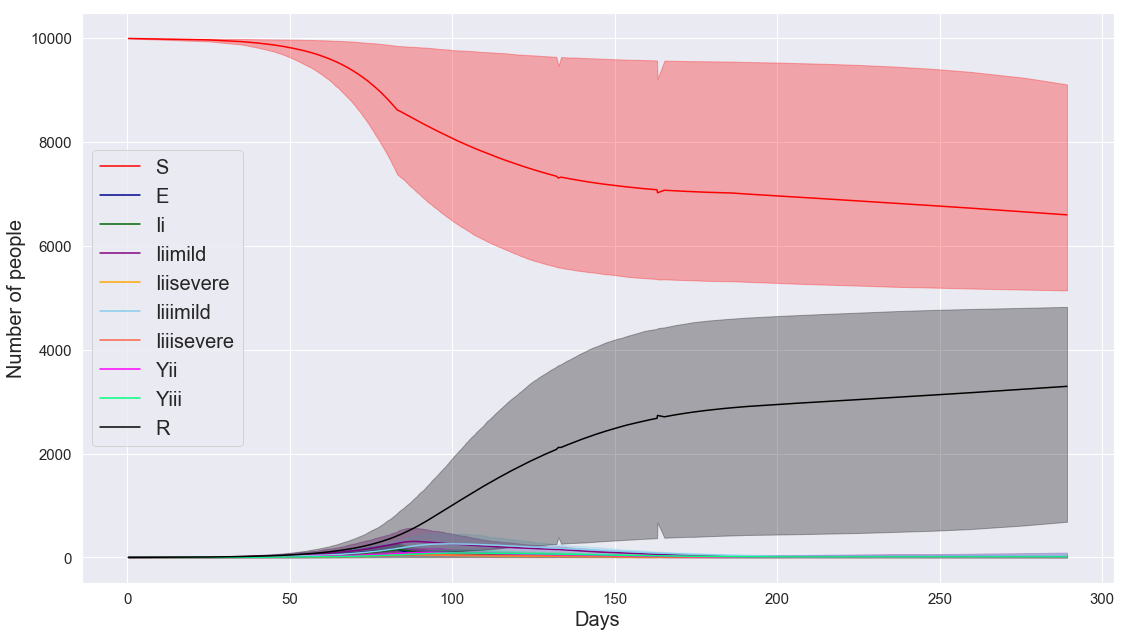

In [17]:
# The number of points to skip per value to make plotting faster
plot_every_n = 100
# Loop over all compartments of the model and plot on the same axes
for lab, col in zip(['S', 'E', 'Ii', 'Iiimild', 'Iiisevere', 'Iiiimild', 'Iiiisevere', 'Yii', 'Yiii', 'R'],
       ['red','darkblue','darkgreen','purple','orange','skyblue','tomato','magenta','springgreen','black']):
    # Compute mean and credible limits
    df = merged_df[[lab+'_'+str(r) for r in range(0,nreals)]]
    df_mean = df.iloc[::plot_every_n, :].mean(axis=1)
    df_lowerCL = df.iloc[::plot_every_n, :].quantile(0.025,axis=1)
    df_upperCL = df.iloc[::plot_every_n, :].quantile(0.975,axis=1)
    # Plot the mean and credible limits in each case
    plt.plot(merged_df.index[::plot_every_n],df_mean.values,color=col,label=lab)
    plt.fill_between(merged_df.index[::plot_every_n],df_lowerCL.values,df_upperCL.values,color=col,alpha=0.3)
# Name axes and rescale plot 
axes = plt.gca()
axes.set_ylabel('Number of people',fontsize=20)
axes.set_xlabel('Days',fontsize=20)
axes.tick_params(labelsize=15)
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.legend(fontsize=20)
plt.show()

And let's look at the corresponding effective reproduction number and epidemic growth rate...

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:60: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.7/site-packages/numpy/lib/function_base.py:1061: RuntimeWarning: divide by zero encountered in true_divide
  a = -(dx2)/(dx1 * (dx1 + dx2))
/usr/local/lib/python3.7/site-packages/numpy/lib/function_base.py:1061: RuntimeWarning: invalid value encountered in true_divide
  a = -(dx2)/(dx1 * (dx1 + dx2))
/usr/local/lib/python3.7/site-packages/numpy/lib/function_base.py:1062: RuntimeWarning: divide by zero encountered in true_divide
  b = (dx2 - dx1) / (dx1 * dx2)
/usr/local/lib/python3.7/site-packages/numpy/lib/function_base.py:1062: RuntimeWarning: invalid value encountered in true_divide
  b = (dx2 - dx1) / (dx1 * dx2)
/usr/local/lib/python3.7/site-packages/numpy/lib/function_base.py:1063: RuntimeWarning: divide by zero encountered in true_divide
  c = dx1 / (dx2 * (dx1 + dx2))
/usr/local/lib/python3.7/site-packages/numpy/lib/function_base.py:1063: Run

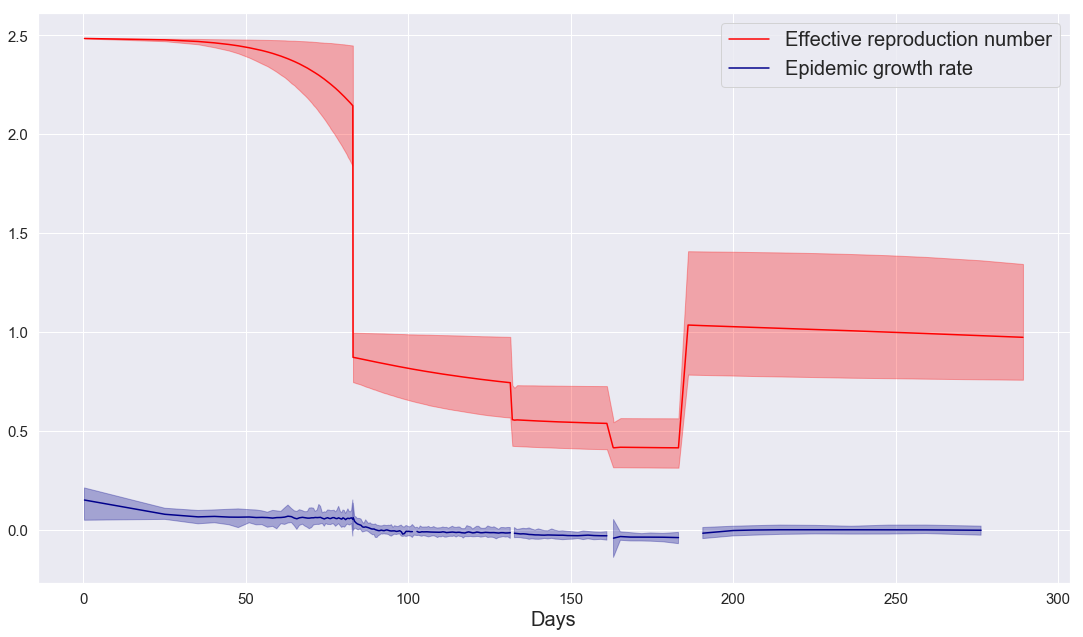

In [19]:
# The number of points to skip per value to make plotting faster
plot_every_n = 100
# Order of centred finite difference used to compute the epidemic growth rate (can be 1 or 2)
order_grad = 2
# Pull out values from merged dataframe
S_df = merged_df[['S_'+str(r) for r in range(0,nreals)]]
E_df = merged_df[['E_'+str(r) for r in range(0,nreals)]]
Ii_df = merged_df[['Ii_'+str(r) for r in range(0,nreals)]]
Iiimild_df = merged_df[['Iiimild_'+str(r) for r in range(0,nreals)]]
Iiisevere_df = merged_df[['Iiisevere_'+str(r) for r in range(0,nreals)]]
Iiiimild_df = merged_df[['Iiiimild_'+str(r) for r in range(0,nreals)]]
Iiiisevere_df = merged_df[['Iiiisevere_'+str(r) for r in range(0,nreals)]]
Yii_df = merged_df[['Yii_'+str(r) for r in range(0,nreals)]]
Yiii_df = merged_df[['Yiii_'+str(r) for r in range(0,nreals)]]
R_df = merged_df[['R_'+str(r) for r in range(0,nreals)]]
# Compute the total infected, the basic and effective reproduction numbers and epidemic growth rate
times = Ii_df.iloc[::plot_every_n, :].index
totpop = S_df.iloc[0,0]+E_df.iloc[0,0]+Ii_df.iloc[0,0]+Iiimild_df.iloc[0,0]+Iiisevere_df.iloc[0,0]+\
         Iiiimild_df.iloc[0,0]+Iiiisevere_df.iloc[0,0]+Yii_df.iloc[0,0]+Yiii_df.iloc[0,0]+R_df.iloc[0,0]
totinf = Ii_df.iloc[::plot_every_n, :].values+Iiimild_df.iloc[::plot_every_n, :].values+\
         Iiisevere_df.iloc[::plot_every_n, :].values+Iiiimild_df.iloc[::plot_every_n, :].values+\
         Iiiisevere_df.iloc[::plot_every_n, :].values+Yii_df.iloc[::plot_every_n, :].values+\
         Yiii_df.iloc[::plot_every_n, :].values
[b, bet, m, g, sig, gam1, gam2, gam3, alph, p, q1, q2, q3] = params_pre
brn_pre = (bet*g/sig) + (bet*q1/gam1) + (bet*(1.0-p)/gam2) + (bet*b*q2*p/(alph+gam2)) + (bet*(1.0-p)/gam3)+\
          (bet*b*q3*gam2*p/(gam3*(alph+gam2))) + (bet*m*q2*alph*p/(gam2*(alph+gam2))) + \
          (bet*m*q3*alph*p/(gam3*(alph+gam2)))
[b, bet, m, g, sig, gam1, gam2, gam3, alph, p, q1, q2, q3] = params_flock
brn_flock = (bet*g/sig) + (bet*q1/gam1) + (bet*(1.0-p)/gam2) + (bet*b*q2*p/(alph+gam2)) + (bet*(1.0-p)/gam3)+\
            (bet*b*q3*gam2*p/(gam3*(alph+gam2))) + (bet*m*q2*alph*p/(gam2*(alph+gam2))) + \
            (bet*m*q3*alph*p/(gam3*(alph+gam2)))
[b, bet, m, g, sig, gam1, gam2, gam3, alph, p, q1, q2, q3] = params_slock
brn_slock = (bet*g/sig) + (bet*q1/gam1) + (bet*(1.0-p)/gam2) + (bet*b*q2*p/(alph+gam2)) + (bet*(1.0-p)/gam3)+\
            (bet*b*q3*gam2*p/(gam3*(alph+gam2))) + (bet*m*q2*alph*p/(gam2*(alph+gam2))) + \
            (bet*m*q3*alph*p/(gam3*(alph+gam2)))
[b, bet, m, g, sig, gam1, gam2, gam3, alph, p, q1, q2, q3] = params_tlock
brn_tlock = (bet*g/sig) + (bet*q1/gam1) + (bet*(1.0-p)/gam2) + (bet*b*q2*p/(alph+gam2)) + (bet*(1.0-p)/gam3)+\
            (bet*b*q3*gam2*p/(gam3*(alph+gam2))) + (bet*m*q2*alph*p/(gam2*(alph+gam2))) + \
            (bet*m*q3*alph*p/(gam3*(alph+gam2)))
[b, bet, m, g, sig, gam1, gam2, gam3, alph, p, q1, q2, q3] = params_post
brn_post = (bet*g/sig) + (bet*q1/gam1) + (bet*(1.0-p)/gam2) + (bet*b*q2*p/(alph+gam2)) + (bet*(1.0-p)/gam3)+\
           (bet*b*q3*gam2*p/(gam3*(alph+gam2))) + (bet*m*q2*alph*p/(gam2*(alph+gam2))) + \
           (bet*m*q3*alph*p/(gam3*(alph+gam2)))
ern = brn_pre*(S_df.iloc[::plot_every_n, :].values/totpop)*\
      (np.tensordot(times,np.ones(nreals),axes=0)<ndays_to_lockdown) + \
      brn_flock*(S_df.iloc[::plot_every_n, :].values/totpop)*\
      (ndays_during_flockdown+ndays_to_lockdown>np.tensordot(times,np.ones(nreals),axes=0))*\
      (np.tensordot(times,np.ones(nreals),axes=0)>=ndays_to_lockdown) + \
      brn_slock*(S_df.iloc[::plot_every_n, :].values/totpop)*\
      (ndays_during_slockdown+ndays_during_flockdown+ndays_to_lockdown>np.tensordot(times,np.ones(nreals),axes=0))*\
      (np.tensordot(times,np.ones(nreals),axes=0)>=ndays_during_flockdown+ndays_to_lockdown) + \
      brn_tlock*(S_df.iloc[::plot_every_n, :].values/totpop)*\
      (ndays_during_tlockdown+ndays_during_slockdown+ndays_during_flockdown+\
       ndays_to_lockdown>np.tensordot(times,np.ones(nreals),axes=0))*\
      (np.tensordot(times,np.ones(nreals),axes=0)>=ndays_during_slockdown+\
       ndays_during_flockdown+ndays_to_lockdown) + \
      brn_post*(S_df.iloc[::plot_every_n, :].values/totpop)*\
      (np.tensordot(times,np.ones(nreals),axes=0)>=ndays_during_tlockdown+ndays_during_slockdown+\
       ndays_during_flockdown+ndays_to_lockdown)
egr = np.gradient(np.log(totinf),times,axis=0,edge_order=order_grad)
# Compute mean and credible limits of the effective reproduction number and epidemic growth rate  
ern_mean = np.nanmean(ern,axis=1)
ern_lowerCL = np.nanquantile(ern,0.025,axis=1)
ern_upperCL = np.nanquantile(ern,0.975,axis=1)
egr_mean = np.nanmean(egr,axis=1)
egr_lowerCL = np.nanquantile(egr,0.025,axis=1)
egr_upperCL = np.nanquantile(egr,0.975,axis=1)
# Plot the mean and credible limits in each case
plt.plot(times,ern_mean,color='red',label='Effective reproduction number')
plt.fill_between(times,ern_lowerCL,ern_upperCL,color='red',alpha=0.3)
plt.plot(times,egr_mean,color='darkblue',label='Epidemic growth rate')
plt.fill_between(times,egr_lowerCL,egr_upperCL,color='darkblue',alpha=0.3)
# Name axes and rescale plot 
axes = plt.gca()
axes.set_xlabel('Days',fontsize=20)
axes.tick_params(labelsize=15)
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.legend(fontsize=20)
plt.show()

And the corresponding standard epidemic curve is...

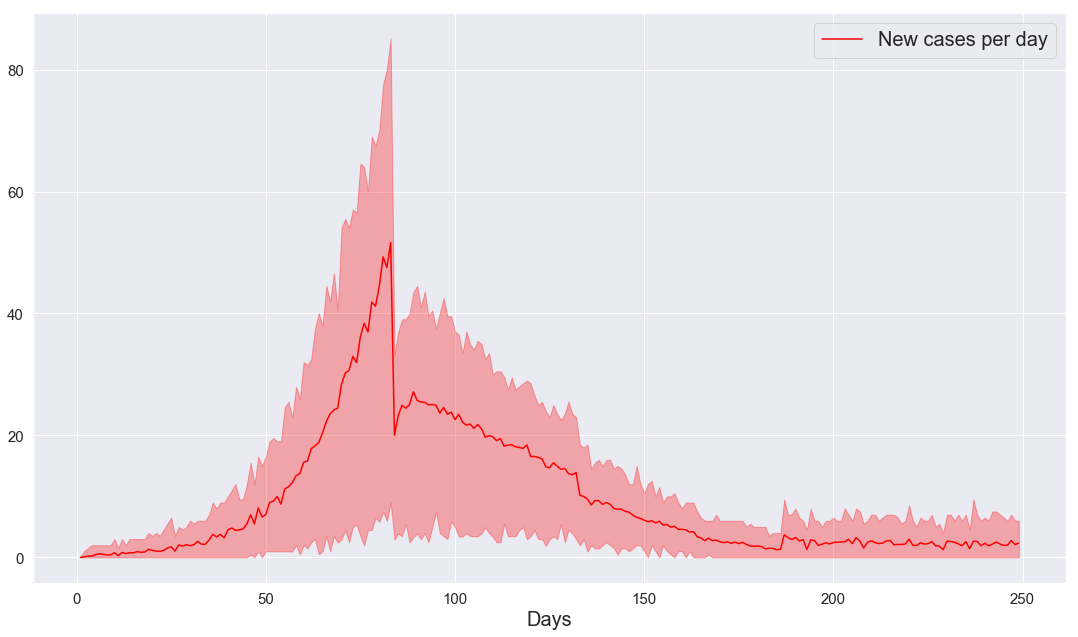

In [20]:
# New cases per day calculation
DE_df = E_df.diff()
DE_df[DE_df<0.0] = 0.0
ncpd_df = DE_df.groupby(pd.cut(E_df.index, np.arange(0, ndays, 1))).sum()
# Compute mean and credible limits of the effective reproduction number and epidemic growth rate  
ncpd_mean = ncpd_df.mean(axis=1)
ncpd_lowerCL = ncpd_df.quantile(0.025,axis=1)
ncpd_upperCL = ncpd_df.quantile(0.975,axis=1)
# Plot the mean and credible limits in each case
plt.plot(np.arange(1, ndays, 1),ncpd_mean,color='red',label='New cases per day')
plt.fill_between(np.arange(1, ndays, 1),ncpd_lowerCL,ncpd_upperCL,color='red',alpha=0.3)
# Name axes and rescale plot 
axes = plt.gca()
axes.set_xlabel('Days',fontsize=20)
axes.tick_params(labelsize=15)
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.legend(fontsize=20)
plt.show()

### Possible approximate modification to include heterogeneity in the number of secondary infections without an IBM (thanks to Ben Collyer for additional insights and code development in this section)

Heterogeneity in the number of secondary infections generated from a single initial infection can clearly be encoded by an individual-based model where an appropriate (e.g., Gamma or Wishart) distribution can be placed on the spreading capacity of an individual to recruit more infections from susceptible $S$ to the incubating class $E$. In the spirit of this notebook keeping the model as simple as possible, we are going to modify the code as it is with a compound Poisson process to attempt to achieve the same goal. If the distribution over the number of secondary infections given an initial infection were a negative binomial (it isn't, but just go with it), then we expect the mean to be $\lambda T$, where $\lambda = \beta  (q_1I_1+I^{\rm mild}_2+I^{\rm mild}_3+bq_2I^{\rm severe}_2+bq_3I^{\rm severe}_3 + mq_2Y_2 + mq_3Y_3 + gE)/N_{\rm tot}$ and $T$ is the mean time of an individual infection. One possible way to generate this heterogeneous distribution would be to draw the number of $S\rightarrow E$ transitions from a compound Poisson process with logseries amplitude. In this process, the number of people to have moved from $S\rightarrow E$ is approximately

$$N_{S\rightarrow E}=\sum^{n}_{i=1}x_i\,, \quad n\sim {\rm Poisson}\bigg[ n;N_{\rm inf}k\ln \bigg( 1+\frac{\lambda T}{N_{\rm inf}k}\bigg) \bigg]\,, \quad x_i \sim {\rm LogSeries}\bigg[ x_i; \bigg(1+\frac{N_{\rm inf}k}{\lambda T}\bigg)^{-1}\bigg] \,.$$

To demonstrate that $N_{S\rightarrow E}$ follows a negative binomial distribution, one notes that its probability generating function $\varphi_{N_{S\rightarrow E}}(z)$ must be

$\varphi_{N_{S\rightarrow E}}(z) = \exp \bigg\{ N_{\rm inf}k\ln \bigg( 1+\frac{\lambda T}{N_{\rm inf}k}\bigg) \big[ \varphi_{x_i}(z) - 1\big]\bigg\} $

$\qquad \qquad = \exp \bigg( N_{\rm inf}k\bigg\{ \ln \bigg[ \frac{N_{\rm inf}k+\lambda T}{N_{\rm inf}k+(1-z)\lambda T}\bigg] - \ln \big( N_{\rm inf}k + \lambda T \big) +\ln N_{\rm inf}k \bigg\} \bigg) $

$\qquad \qquad = \bigg[ 1+ (1-z)\frac{\lambda T}{N_{\rm inf}k}\bigg]^{-N_{\rm inf}k}\,.$

This is the probability generating function of a negative binomial with mean $\lambda T$ and the sum of $N_{\rm inf}=I_1+I^{\rm mild}_2+I^{\rm severe}_2+I^{\rm mild}_3+I^{\rm severe}_3+Y_2+Y_3+E$ aggregations, $N_{\rm inf}k$. Note that across individuals, the time to clear infection will randomly fluctuate around $T$, in the simulation the variance of this distribution will appear to be larger. Taking $\tau$ to be a random variable which represents the lifetime of an individual infection in the simulation, we can calculate the mean and variance as follows 

$$\tau = (1-p)\tau_{I_1\rightarrow I_2^{\rm mild}\rightarrow I_3^{\rm mild} \rightarrow R} +\frac{p\gamma_2}{\alpha + \gamma_2}\tau_{I_1\rightarrow I_2^{\rm severe}\rightarrow I_3^{\rm severe} \rightarrow R}+\frac{p\alpha}{\alpha + \gamma_2}\tau_{I_1\rightarrow I_2^{\rm severe}\rightarrow Y_2\rightarrow Y_3 \rightarrow R}$$

$$T={\rm E}(\tau) = (1-p)\bigg( \frac{1}{\gamma_1} +  \frac{1}{\gamma_2} +  \frac{1}{\gamma_3}\bigg) +\frac{p\gamma_2}{\alpha + \gamma_2}\bigg( \frac{1}{\gamma_1} +  \frac{1}{\gamma_2} +  \frac{1}{\gamma_3}\bigg)+\frac{p\alpha}{\alpha + \gamma_2}\bigg( \frac{1}{\gamma_1} + \frac{1}{\alpha} +  \frac{1}{\gamma_2} +  \frac{1}{\gamma_3}\bigg)$$

$${\rm Var}(\tau) = (1-p)\bigg( \frac{1}{\gamma_1^2} +  \frac{1}{\gamma_2^2} +  \frac{1}{\gamma_3^2}\bigg) +\frac{p\gamma_2}{\alpha + \gamma_2}\bigg( \frac{1}{\gamma_1^2} +  \frac{1}{\gamma_2^2} +  \frac{1}{\gamma_3^2}\bigg)+\frac{p\alpha}{\alpha + \gamma_2}\bigg( \frac{1}{\gamma_1^2} + \frac{1}{\alpha^2} +  \frac{1}{\gamma_2^2} +  \frac{1}{\gamma_3^2}\bigg)\,.$$

The additional variance and approximate aggregation $k_{\rm approx}$ (approximate because the distribution in the simulation isn't strictly negative binomial) over $N_{S\rightarrow E}$, which arises from multiple individuals in the simulation, can hence be computed as follows

$${\rm Var}(N_{S\rightarrow E}) = {\rm E}_\tau \bigg[{\rm E}(N_{S\rightarrow E} \vert \tau ) + \frac{{\rm E}(N_{S\rightarrow E} \vert \tau )^2}{k}\bigg] = {\rm E}_\tau \bigg( \lambda \tau + \frac{\lambda^2\tau^2}{k}\bigg) = \lambda T + \frac{\lambda^2T^2+\lambda^2{\rm Var}(\tau)}{k}$$

$$\Longrightarrow \,\, k_{\rm approx} = \frac{\lambda^2 T^2}{{\rm Var}(N_{S\rightarrow E})-\lambda T} = \frac{T^2}{T^2+{\rm Var}(\tau)}k\,.$$

To obtain a negative binomial distribution over the number of secondary infections in the simulation, we iteratively update $\lambda$ according to the numbers of infectives and use this value to compute a rate for the $S\rightarrow E$ transition for $N_{\rm inf}$ infectives interacting with the population. The resulting simulation is...

In [5]:
# Added the aggregation parameter k here
b,bet,m,g,sig,gam1,gam2,gam3,alph,p,q1,q2,q3,kapp = 1.0,0.124,1.0,0.0,1.0/2.42,1.0/2.42,0.1,0.1,\
                                                    0.195,0.33,1.0,0.64,0.64,0.3
S,E,I1,I2mild,I2severe,I3mild,I3severe,Y2,Y3,R = 9995,5,0,0,0,0,0,0,0,0
nreals = 100
ndays = 250
# Package parameters and initial conditions all together
params = [b, bet, m, g, sig, gam1, gam2, gam3, alph, p, q1, q2, q3, kapp]
initconds = [S*np.ones(nreals),E*np.ones(nreals), I1*np.ones(nreals), I2mild*np.ones(nreals),\
             I2severe*np.ones(nreals), I3mild*np.ones(nreals), I3severe*np.ones(nreals), Y2*np.ones(nreals),\
             Y3*np.ones(nreals), R*np.ones(nreals)]
# Define model function to output after specified time period
def covid_simple_het(initconds,params,reals,runtime,output_to_file): 
    # Open storage for output to file
    f = open(output_to_file, "w")
    # Unpack parameters and initial conditions
    [b, bet, m, g, sig, gam1, gam2, gam3, alph, p, q1, q2, q3, kapp] = params
    [S, E, I1, I2mild, I2severe, I3mild, I3severe, Y2, Y3, R] = initconds 
    # Convert to float because I'm like that...
    runtime = float(runtime)   
    # Compute total population number for each realisation
    Ntot = S+E+I1+I2mild+I2severe+I3mild+I3severe+Y2+Y3+R
    # Compute the basic reproduction number and, mean infectious time, variance of the infectious time
    # and variance-corrected aggregation parameter prior to the simulation loop
    brn = (bet*g/sig) + (bet*q1/gam1) + (bet*(1.0-p)/gam2) + (bet*b*q2*p/(alph+gam2)) + (bet*(1.0-p)/gam3)+\
          (bet*b*q3*gam2*p/(gam3*(alph+gam2))) + (bet*m*q2*alph*p/(gam2*(alph+gam2))) + \
          (bet*m*q3*alph*p/(gam3*(alph+gam2)))
    T = ((1.0-p)+(p*gam2/(alph+gam2))+(p*alph/(alph+gam2)))*((1.0/gam1)+(1.0/gam2)+(1.0/gam3)) + (p/(alph+gam2))
    Vartau = ((1.0-p)+(p*gam2/(alph+gam2))+(p*alph/(alph+gam2)))*((1.0/(gam1**2.0))+(1.0/(gam2**2.0))+ \
             (1.0/(gam3**2.0))) + (p*alph/(((alph**2.0)*(alph>0.0) + (alph==0.0))*(alph+gam2)))
    # Compute variance-corrected aggregation value
    k = kapp*(Vartau+(T**2.0))/(T**2.0)
    # Main loop
    t = np.zeros(reals)
    terminated = np.ones(reals)
    while np.any(t < runtime):
        # Terminate loop if everyone has recovered
        if np.all(S+E+I1+I2mild+I2severe+I3mild+I3severe+Y2+Y3) == 0: break            
        # Update the event rates
        old_rate_S_E = bet*(q1*I1+I2mild+b*q2*I2severe+I3mild+b*q3*I3severe+m*q2*Y2+m*q3*Y3+g*E)*S/Ntot
        N_inf = I1+I2mild+I2severe+I3mild+I3severe+Y2+Y3+E
        # Note the new rate_S_E divides by T for dimensions. Note that k=0 causes issues so np.maximum is used
        kN = k*np.maximum(1,N_inf)
        rate_S_E = kN*np.log(1.0+(old_rate_S_E*T/kN))/T 
        rate_E_I1, rate_I1_I2, rate_I2severe_Y2 = sig*E, gam1*I1, alph*I2severe
        rate_I2mild_I3mild, rate_I2severe_I3severe, rate_Y2_Y3 = gam2*I2mild, gam2*I2severe, gam2*Y2
        rate_I3mild_R, rate_I3severe_R, rate_Y3_R = gam3*I3mild, gam3*I3severe, gam3*Y3       
        # Sum the rates
        rate_sum = rate_S_E + rate_E_I1 + rate_I1_I2 + rate_I2severe_Y2 + rate_I2mild_I3mild + \
                   rate_I2severe_I3severe + rate_Y2_Y3 + rate_I3mild_R + rate_I3severe_R + rate_Y3_R
        # Avoid pathologies at the end
        rate_sum[rate_sum<=0.0] = 1.0
        # Take step forward in time and determine when to stop each run
        t = t + terminated*np.random.exponential(1.0/rate_sum,size=reals) 
        terminated = (t<runtime)
        # Choose the event to occur in each realisation
        severe = np.random.binomial(1,p,size=reals)
        event = np.random.uniform(size=reals)
        event_probs = np.asarray([rate_S_E/rate_sum,rate_E_I1/rate_sum,\
                                  rate_I1_I2/rate_sum,rate_I2severe_Y2/rate_sum,rate_I2mild_I3mild/rate_sum,\
                                  rate_I2severe_I3severe/rate_sum,rate_Y2_Y3/rate_sum,rate_I3mild_R/rate_sum,\
                                  rate_I3severe_R/rate_sum,rate_Y3_R/rate_sum])
        cumul_probs = np.cumsum(event_probs,axis=0)
        # Draw logseries S -> E event transition numbers for each realisation
        num_S_E = np.random.logseries((1.0+(kN/(old_rate_S_E*T)))**(-1.0),size=reals)
        # Make sure these don't exceed the actual number of susceptibles
        num_S_E = S*(num_S_E>S) + num_S_E*(num_S_E<=S)
        # S -> E (note new event number)
        S = S - terminated*(event<cumul_probs[0])*num_S_E
        # S -> E, E -> I1 (note new event number)
        E = E + terminated*(event<cumul_probs[0])*num_S_E - terminated*(cumul_probs[1]>event)*(event>=cumul_probs[0])
        # E -> I1, I1 -> I2
        I1 = I1 + terminated*(cumul_probs[1]>event)*(event>=cumul_probs[0]) \
                - terminated*(cumul_probs[2]>event)*(event>=cumul_probs[1])
        # I1 -> I2mild, I2mild -> I3mild
        I2mild = I2mild + terminated*(severe==0)*(cumul_probs[2]>event)*(event>=cumul_probs[1]) \
                        - terminated*(cumul_probs[4]>event)*(event>=cumul_probs[3])
        # I1 -> I2severe, I2severe -> Y2, I2severe -> I3severe
        I2severe = I2severe + terminated*(severe==1)*(cumul_probs[2]>event)*(event>=cumul_probs[1]) \
                            - terminated*(cumul_probs[3]>event)*(event>=cumul_probs[2]) \
                            - terminated*(cumul_probs[5]>event)*(event>=cumul_probs[4])
        # I2mild -> I3mild, I3mild -> R
        I3mild = I3mild + terminated*(cumul_probs[4]>event)*(event>=cumul_probs[3]) \
                        - terminated*(cumul_probs[7]>event)*(event>=cumul_probs[6])
        # I2severe -> I3severe, I3severe -> R
        I3severe = I3severe + terminated*(cumul_probs[5]>event)*(event>=cumul_probs[4]) \
                            - terminated*(cumul_probs[8]>event)*(event>=cumul_probs[7])
        # I2severe -> Y2, Y2 -> Y3
        Y2 = Y2 + terminated*(cumul_probs[3]>event)*(event>=cumul_probs[2]) \
                - terminated*(cumul_probs[6]>event)*(event>=cumul_probs[5])
        # Y2 -> Y3, Y3 -> R
        Y3 = Y3 + terminated*(cumul_probs[6]>event)*(event>=cumul_probs[5]) \
                - terminated*(cumul_probs[9]>event)*(event>=cumul_probs[8])
        # I3mild -> R, I3severe -> R, Y3 -> R
        R = R + terminated*(cumul_probs[7]>event)*(event>=cumul_probs[6]) \
              + terminated*(cumul_probs[8]>event)*(event>=cumul_probs[7]) \
              + terminated*(cumul_probs[9]>event)*(event>=cumul_probs[8])
        # Store values in file
        f.write(','.join(map(str,np.concatenate([t, S, E, I1, I2mild, I2severe, \
                                                 I3mild, I3severe, Y2, Y3, R]).ravel().tolist()))+'\n')
        f.flush()
    # Close file
    f.close()
    # Setup output column name list
    column_names = []
    for l in ['t', 'S', 'E', 'Ii', 'Iiimild', 'Iiisevere', 'Iiiimild', 'Iiiisevere', 'Yii', 'Yiii', 'R']:
        for r in range(0,nreals):
            column_names.append(l+'_'+str(r))
    # Load dataframe with column names
    df = pd.read_csv(output_to_file,names=column_names)
    # Create dictionary of sub dataframes from output for each time series realisation
    dict_of_dfs = {}
    for r in range(0,nreals):
        dict_of_dfs['real_'+str(r)] = df[['t_'+str(r), 'S_'+str(r), 'E_'+str(r), 'Ii_'+str(r),\
                                          'Iiimild_'+str(r), 'Iiisevere_'+str(r), 'Iiiimild_'+str(r),\
                                          'Iiiisevere_'+str(r), 'Yii_'+str(r), 'Yiii_'+str(r), 'R_'+str(r)]]
        # Strip the time column of its number for merging
        dict_of_dfs['real_'+str(r)].columns = dict_of_dfs['real_'+str(r)].columns.str.rstrip('_'+str(r))
    # Output resulting compartment numbers to a dictionary of pandas dataframes
    return dict_of_dfs

In [6]:
# Run code and obtain dictionary of dataframes output
ddf = covid_simple_het(initconds,params,nreals,ndays,'plot_data/non-lockdown-hetero.csv')
# Map all column names onto their realisation numbers (apart from time) to avoid merge clashes
merged_df = ddf['real_0']
merged_df.columns = merged_df.columns.map(lambda c: c+'_0' if c!='t' else c)
for r in range(1,nreals):
    ddf['real_'+str(r)].columns = ddf['real_'+str(r)].columns.map(lambda c: c+'_'+str(r) if c!='t' else c)
    merged_df = pd.merge_asof(merged_df,ddf['real_'+str(r)],on='t')
# Set index to time
merged_df = merged_df.set_index('t')
merged_df

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:65: RuntimeWarning: divide by zero encountered in true_divide


,S_0,E_0,Ii_0,Iiimild_0,Iiisevere_0,Iiiimild_0,Iiiisevere_0,Yii_0,Yiii_0,R_0,...,S_99,E_99,Ii_99,Iiimild_99,Iiisevere_99,Iiiimild_99,Iiiisevere_99,Yii_99,Yiii_99,R_99
t,,,,,,,,,,,,,,,,,,,,,
0.196368,9995.0,4.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.582298,9995.0,3.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1.382067,9995.0,2.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,9995.0,3.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1.396485,9995.0,2.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,9995.0,3.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1.997650,9995.0,2.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,9994.0,4.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
250.087406,1049.0,0.0,0.0,0.0,0.0,2.0,0.0,2.0,2.0,8945.0,...,1090.0,0.0,0.0,4.0,0.0,7.0,0.0,2.0,5.0,8892.0
250.087406,1049.0,0.0,0.0,0.0,0.0,2.0,0.0,2.0,2.0,8945.0,...,1090.0,0.0,0.0,4.0,0.0,7.0,0.0,2.0,5.0,8892.0
250.087406,1049.0,0.0,0.0,0.0,0.0,2.0,0.0,2.0,2.0,8945.0,...,1090.0,0.0,0.0,4.0,0.0,7.0,0.0,2.0,5.0,8892.0


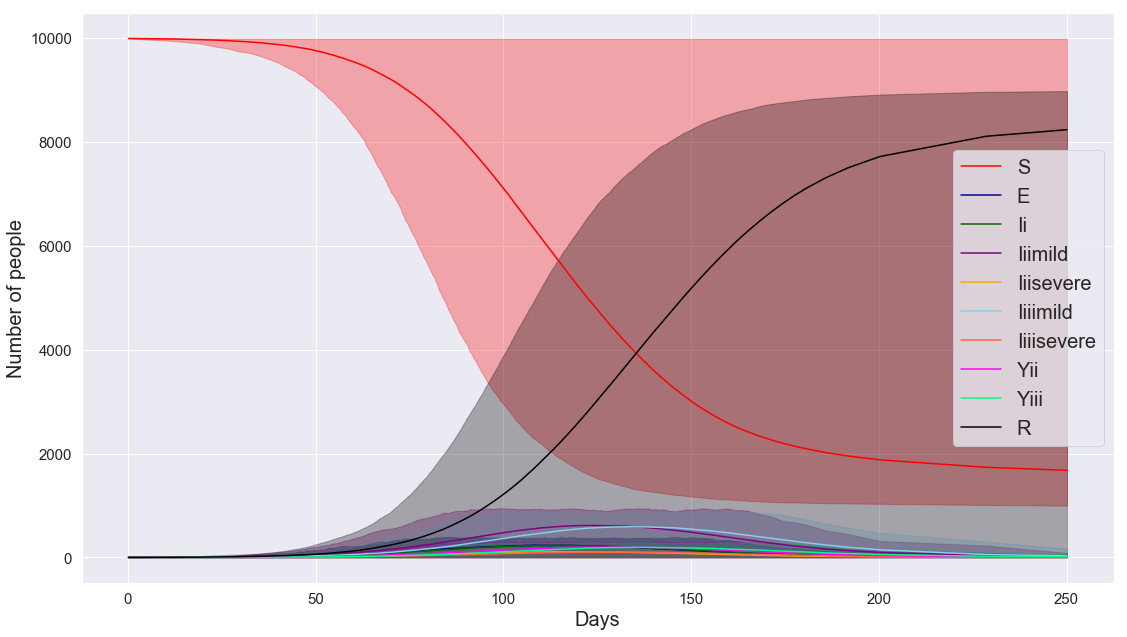

In [7]:
# The number of points to skip per value to make plotting faster
plot_every_n = 100
# Loop over all compartments of the model and plot on the same axes
for lab, col in zip(['S', 'E', 'Ii', 'Iiimild', 'Iiisevere', 'Iiiimild', 'Iiiisevere', 'Yii', 'Yiii', 'R'],
       ['red','darkblue','darkgreen','purple','orange','skyblue','tomato','magenta','springgreen','black']):
    # Compute mean and credible limits
    df = merged_df[[lab+'_'+str(r) for r in range(0,nreals)]]
    df_mean = df.iloc[::plot_every_n, :].mean(axis=1)
    df_lowerCL = df.iloc[::plot_every_n, :].quantile(0.025,axis=1)
    df_upperCL = df.iloc[::plot_every_n, :].quantile(0.975,axis=1)
    # Plot the mean and credible limits in each case
    plt.plot(merged_df.index[::plot_every_n],df_mean.values,color=col,label=lab)
    plt.fill_between(merged_df.index[::plot_every_n],df_lowerCL.values,df_upperCL.values,color=col,alpha=0.3)
# Name axes and rescale plot 
axes = plt.gca()
axes.set_ylabel('Number of people',fontsize=20)
axes.set_xlabel('Days',fontsize=20)
axes.tick_params(labelsize=15)
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.legend(fontsize=20)
plt.show()

And the corresponding standard epidemic curve is...

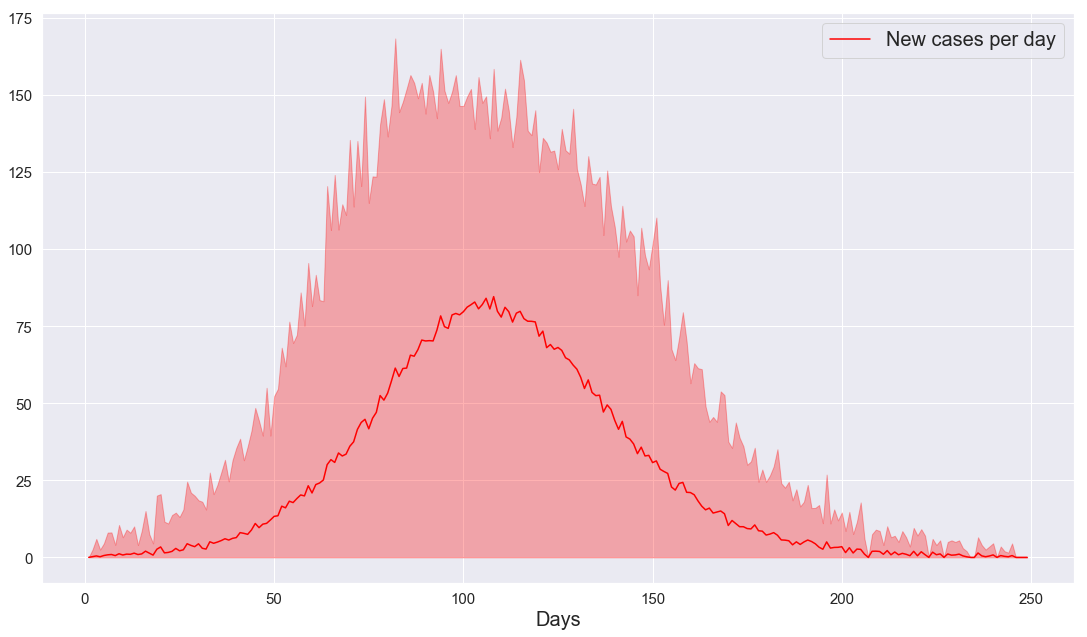

In [9]:
# Obtain the incubating numbers from merged dataframe
E_df = merged_df[['E_'+str(r) for r in range(0,nreals)]]
# New cases per day calculation
DE_df = E_df.diff()
DE_df[DE_df<0.0] = 0.0
ncpd_df = DE_df.groupby(pd.cut(E_df.index, np.arange(0, ndays, 1))).sum()
# Compute mean and credible limits of the effective reproduction number and epidemic growth rate  
ncpd_mean = ncpd_df.mean(axis=1)
ncpd_lowerCL = ncpd_df.quantile(0.025,axis=1)
ncpd_upperCL = ncpd_df.quantile(0.975,axis=1)
# Plot the mean and credible limits in each case
plt.plot(np.arange(1, ndays, 1),ncpd_mean,color='red',label='New cases per day')
plt.fill_between(np.arange(1, ndays, 1),ncpd_lowerCL,ncpd_upperCL,color='red',alpha=0.3)
# Name axes and rescale plot 
axes = plt.gca()
axes.set_xlabel('Days',fontsize=20)
axes.tick_params(labelsize=15)
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.legend(fontsize=20)
ncpd_df.to_csv('plot_data/new_cases_per_day.csv')
plt.show()

### Mimicking lockdown in the heterogeneous model

The last step in this notebook is to take the heterogeneous model derived above and use it to mimic lockdown as we did above...

In [6]:
# Number of days to run pre-lockdown
ndays_to_lockdown = 83
# Number of days to run during first phase of lockdown
ndays_during_flockdown = 49
# Number of days to run during second phase of lockdown
ndays_during_slockdown = 31
# Number of days to run during third phase of lockdown
ndays_during_tlockdown = 23
# Number of days to run post-lockdown
ndays_beyond_lockdown = 103
# Pre-lockdown parameters and initial conditions
b,bet,m,g,sig,gam1,gam2,gam3,alph,p,q1,q2,q3,kapp = 1.0,0.124,1.0,0.0,1.0/2.42,1.0/2.42,0.1,0.1,\
                                                    0.195,0.33,1.0,0.64,0.64,0.3
S,E,I1,I2mild,I2severe,I3mild,I3severe,Y2,Y3,R = 9995,5,0,0,0,0,0,0,0,0
# Package parameters and initial conditions all together
params_pre = [b, bet, m, g, sig, gam1, gam2, gam3, alph, p, q1, q2, q3, kapp]
initconds_pre = [S*np.ones(nreals),E*np.ones(nreals), I1*np.ones(nreals), I2mild*np.ones(nreals),\
                 I2severe*np.ones(nreals), I3mild*np.ones(nreals), I3severe*np.ones(nreals), Y2*np.ones(nreals),\
                 Y3*np.ones(nreals), R*np.ones(nreals)]
# Run pre-lockdown pandemic
ddf_pre = covid_simple_het(initconds_pre,params_pre,nreals,ndays_to_lockdown,'plot_data/pre-lockdown-hetero.csv')
# FIRST PHASE
# Map all column names onto their realisation numbers (apart from time) to avoid merge clashes
merged_df_pre = ddf_pre['real_0']
merged_df_pre.columns = merged_df_pre.columns.map(lambda c: c+'_0' if c!='t' else c)
for r in range(1,nreals):
    ddf_pre['real_'+str(r)].columns = ddf_pre['real_'+str(r)].columns.map(lambda c: c+'_'+str(r) if c!='t' else c)
    merged_df_pre = pd.merge_asof(merged_df_pre,ddf_pre['real_'+str(r)],on='t')
# Set index to time
merged_df_pre = merged_df_pre.set_index('t')
# Pull out values from merged pre-lockdown dataframe
S_df_pre = merged_df_pre[['S_'+str(r) for r in range(0,nreals)]]
E_df_pre = merged_df_pre[['E_'+str(r) for r in range(0,nreals)]]
Ii_df_pre = merged_df_pre[['Ii_'+str(r) for r in range(0,nreals)]]
Iiimild_df_pre = merged_df_pre[['Iiimild_'+str(r) for r in range(0,nreals)]]
Iiisevere_df_pre = merged_df_pre[['Iiisevere_'+str(r) for r in range(0,nreals)]]
Iiiimild_df_pre = merged_df_pre[['Iiiimild_'+str(r) for r in range(0,nreals)]]
Iiiisevere_df_pre = merged_df_pre[['Iiiisevere_'+str(r) for r in range(0,nreals)]]
Yii_df_pre = merged_df_pre[['Yii_'+str(r) for r in range(0,nreals)]]
Yiii_df_pre = merged_df_pre[['Yiii_'+str(r) for r in range(0,nreals)]]
R_df_pre = merged_df_pre[['R_'+str(r) for r in range(0,nreals)]]
# Update the parameters and initial conditions for the first lockdown runs
b,bet,m,g,sig,gam1,gam2,gam3,alph,p,q1,q2,q3,kapp = 0.8,0.124,0.01,0.0,1.0/2.42,1.0/2.42,0.1,0.1,\
                                                    0.195,0.33,1.0,0.64,0.64,0.3
bet = 0.48*bet # During first phase lockdown everyones' infectiousness is assumed to drop by this factor
params_flock = [b, bet, m, g, sig, gam1, gam2, gam3, alph, p, q1, q2, q3, kapp]
initconds_flock = [S_df_pre.values[-1],E_df_pre.values[-1], Ii_df_pre.values[-1], Iiimild_df_pre.values[-1],\
                   Iiisevere_df_pre.values[-1], Iiiimild_df_pre.values[-1], Iiiisevere_df_pre.values[-1],\
                   Yii_df_pre.values[-1],Yiii_df_pre.values[-1], R_df_pre.values[-1]]
# Run first phase lockdown pandemic
ddf_flock = covid_simple_het(initconds_flock,params_flock,\
                             nreals,ndays_during_flockdown,'plot_data/first-lockdown-hetero.csv')
# SECOND PHASE
# Map all column names onto their realisation numbers (apart from time) to avoid merge clashes
merged_df_flock = ddf_flock['real_0']
merged_df_flock.columns = merged_df_flock.columns.map(lambda c: c+'_0' if c!='t' else c)
for r in range(1,nreals):
    ddf_flock['real_'+str(r)].columns = ddf_flock['real_'+str(r)].columns.map(lambda c: c+'_'+str(r) if c!='t' else c)
    merged_df_flock = pd.merge_asof(merged_df_flock,ddf_flock['real_'+str(r)],on='t')
# Set index to time
merged_df_flock = merged_df_flock.set_index('t')
# Pull out values from merged first phase lockdown dataframe
S_df_flock = merged_df_flock[['S_'+str(r) for r in range(0,nreals)]]
E_df_flock = merged_df_flock[['E_'+str(r) for r in range(0,nreals)]]
Ii_df_flock = merged_df_flock[['Ii_'+str(r) for r in range(0,nreals)]]
Iiimild_df_flock = merged_df_flock[['Iiimild_'+str(r) for r in range(0,nreals)]]
Iiisevere_df_flock = merged_df_flock[['Iiisevere_'+str(r) for r in range(0,nreals)]]
Iiiimild_df_flock = merged_df_flock[['Iiiimild_'+str(r) for r in range(0,nreals)]]
Iiiisevere_df_flock = merged_df_flock[['Iiiisevere_'+str(r) for r in range(0,nreals)]]
Yii_df_flock = merged_df_flock[['Yii_'+str(r) for r in range(0,nreals)]]
Yiii_df_flock = merged_df_flock[['Yiii_'+str(r) for r in range(0,nreals)]]
R_df_flock = merged_df_flock[['R_'+str(r) for r in range(0,nreals)]]
# Update the parameters and initial conditions for the lockdown runs
b,bet,m,g,sig,gam1,gam2,gam3,alph,p,q1,q2,q3,kapp = 0.8,0.124,0.01,0.0,1.0/2.42,1.0/2.42,0.1,0.1,\
                                                    0.195,0.33,1.0,0.64,0.64,0.3
bet = 0.36*bet # During second phase lockdown everyones' infectiousness is assumed to drop by this factor
params_slock = [b, bet, m, g, sig, gam1, gam2, gam3, alph, p, q1, q2, q3, kapp]
initconds_slock = [S_df_flock.values[-1],E_df_flock.values[-1], Ii_df_flock.values[-1], Iiimild_df_flock.values[-1],\
                   Iiisevere_df_flock.values[-1], Iiiimild_df_flock.values[-1], Iiiisevere_df_flock.values[-1],\
                   Yii_df_flock.values[-1],Yiii_df_flock.values[-1], R_df_flock.values[-1]]
# Run second phase lockdown pandemic
ddf_slock = covid_simple_het(initconds_slock,params_slock,\
                             nreals,ndays_during_slockdown,'plot_data/second-lockdown-hetero.csv')
# THIRD PHASE
# Map all column names onto their realisation numbers (apart from time) to avoid merge clashes
merged_df_slock = ddf_slock['real_0']
merged_df_slock.columns = merged_df_slock.columns.map(lambda c: c+'_0' if c!='t' else c)
for r in range(1,nreals):
    ddf_slock['real_'+str(r)].columns = ddf_slock['real_'+str(r)].columns.map(lambda c: c+'_'+str(r) if c!='t' else c)
    merged_df_slock = pd.merge_asof(merged_df_slock,ddf_slock['real_'+str(r)],on='t')
# Set index to time
merged_df_slock = merged_df_slock.set_index('t')
# Pull out values from merged second phase lockdown dataframe
S_df_slock = merged_df_slock[['S_'+str(r) for r in range(0,nreals)]]
E_df_slock = merged_df_slock[['E_'+str(r) for r in range(0,nreals)]]
Ii_df_slock = merged_df_slock[['Ii_'+str(r) for r in range(0,nreals)]]
Iiimild_df_slock = merged_df_slock[['Iiimild_'+str(r) for r in range(0,nreals)]]
Iiisevere_df_slock = merged_df_slock[['Iiisevere_'+str(r) for r in range(0,nreals)]]
Iiiimild_df_slock = merged_df_slock[['Iiiimild_'+str(r) for r in range(0,nreals)]]
Iiiisevere_df_slock = merged_df_slock[['Iiiisevere_'+str(r) for r in range(0,nreals)]]
Yii_df_slock = merged_df_slock[['Yii_'+str(r) for r in range(0,nreals)]]
Yiii_df_slock = merged_df_slock[['Yiii_'+str(r) for r in range(0,nreals)]]
R_df_slock = merged_df_slock[['R_'+str(r) for r in range(0,nreals)]]
# Update the parameters and initial conditions for the lockdown runs
b,bet,m,g,sig,gam1,gam2,gam3,alph,p,q1,q2,q3,kapp = 0.8,0.124,0.01,0.0,1.0/2.42,1.0/2.42,0.1,0.1,\
                                                    0.195,0.33,1.0,0.64,0.64,0.3
bet = 0.28*bet # During third phase lockdown everyones' infectiousness is assumed to drop by this factor
params_tlock = [b, bet, m, g, sig, gam1, gam2, gam3, alph, p, q1, q2, q3, kapp]
initconds_tlock = [S_df_slock.values[-1],E_df_slock.values[-1], Ii_df_slock.values[-1], Iiimild_df_slock.values[-1],\
                  Iiisevere_df_slock.values[-1], Iiiimild_df_slock.values[-1], Iiiisevere_df_slock.values[-1],\
                  Yii_df_slock.values[-1],Yiii_df_slock.values[-1], R_df_slock.values[-1]]
# Run post-lockdown pandemic
ddf_tlock = covid_simple_het(initconds_tlock,params_tlock,nreals,\
                             ndays_during_tlockdown,'plot_data/third-lockdown-hetero.csv')
# Map all column names onto their realisation numbers (apart from time) to avoid merge clashes
merged_df_tlock = ddf_tlock['real_0']
merged_df_tlock.columns = merged_df_tlock.columns.map(lambda c: c+'_0' if c!='t' else c)
for r in range(1,nreals):
    ddf_tlock['real_'+str(r)].columns = ddf_tlock['real_'+str(r)].columns.map(lambda c: c+'_'+str(r) if c!='t' else c)
    merged_df_tlock = pd.merge_asof(merged_df_tlock,ddf_tlock['real_'+str(r)],on='t')
# Set index to time
merged_df_tlock = merged_df_tlock.set_index('t')
# Pull out values from merged lockdown dataframe
S_df_tlock = merged_df_tlock[['S_'+str(r) for r in range(0,nreals)]]
E_df_tlock = merged_df_tlock[['E_'+str(r) for r in range(0,nreals)]]
Ii_df_tlock = merged_df_tlock[['Ii_'+str(r) for r in range(0,nreals)]]
Iiimild_df_tlock = merged_df_tlock[['Iiimild_'+str(r) for r in range(0,nreals)]]
Iiisevere_df_tlock = merged_df_tlock[['Iiisevere_'+str(r) for r in range(0,nreals)]]
Iiiimild_df_tlock = merged_df_tlock[['Iiiimild_'+str(r) for r in range(0,nreals)]]
Iiiisevere_df_tlock = merged_df_tlock[['Iiiisevere_'+str(r) for r in range(0,nreals)]]
Yii_df_tlock = merged_df_tlock[['Yii_'+str(r) for r in range(0,nreals)]]
Yiii_df_tlock = merged_df_tlock[['Yiii_'+str(r) for r in range(0,nreals)]]
R_df_tlock = merged_df_tlock[['R_'+str(r) for r in range(0,nreals)]]
# Update the parameters and initial conditions for the post-lockdown runs
b,bet,m,g,sig,gam1,gam2,gam3,alph,p,q1,q2,q3,kapp = 0.8,0.124,0.01,0.0,1.0/2.42,1.0/2.42,0.1,0.1,\
                                                    0.195,0.33,1.0,0.64,0.64,0.3
bet = 0.7*bet # Post-lockdown everyones' infectiousness is assumed to return up to this factor
params_post = [b, bet, m, g, sig, gam1, gam2, gam3, alph, p, q1, q2, q3, kapp]
initconds_post = [S_df_tlock.values[-1],E_df_tlock.values[-1], Ii_df_tlock.values[-1], Iiimild_df_tlock.values[-1],\
                  Iiisevere_df_tlock.values[-1], Iiiimild_df_tlock.values[-1], Iiiisevere_df_tlock.values[-1],\
                  Yii_df_tlock.values[-1],Yiii_df_tlock.values[-1], R_df_tlock.values[-1]]
# Run post-lockdown pandemic
ddf_post = covid_simple_het(initconds_post,params_post,nreals,\
                            ndays_beyond_lockdown,'plot_data/post-lockdown-hetero.csv')
# Map all column names onto their realisation numbers (apart from time) to avoid merge clashes
merged_df_post = ddf_post['real_0']
merged_df_post.columns = merged_df_post.columns.map(lambda c: c+'_0' if c!='t' else c)
for r in range(1,nreals):
    ddf_post['real_'+str(r)].columns = ddf_post['real_'+str(r)].columns.map(lambda c: c+'_'+str(r) if c!='t' else c)
    merged_df_post = pd.merge_asof(merged_df_post,ddf_post['real_'+str(r)],on='t')
# Set index to time
merged_df_post = merged_df_post.set_index('t')
# Add days to the total time in the lockdown and pre-lockdown dataframes
merged_df_flock.index = merged_df_flock.index + ndays_to_lockdown
merged_df_slock.index = merged_df_slock.index + ndays_during_flockdown + ndays_to_lockdown
merged_df_tlock.index = merged_df_tlock.index + ndays_during_slockdown + ndays_during_flockdown + ndays_to_lockdown
merged_df_post.index = merged_df_post.index + ndays_during_tlockdown + ndays_during_slockdown + \
                                              ndays_during_flockdown + ndays_to_lockdown
# Append the lockdown dataframe to the pre-lockdown dataframe and the post-lockdown dataframe to the result
merged_df = merged_df_pre.append(merged_df_flock)
merged_df = merged_df.append(merged_df_slock)
merged_df = merged_df.append(merged_df_tlock)
merged_df = merged_df.append(merged_df_post)
# Save this merged dataframe to csv
merged_df.to_csv('plot_data/lockdown-scenario-hetero.csv')

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:65: RuntimeWarning: divide by zero encountered in true_divide


Let's first see the compartments...

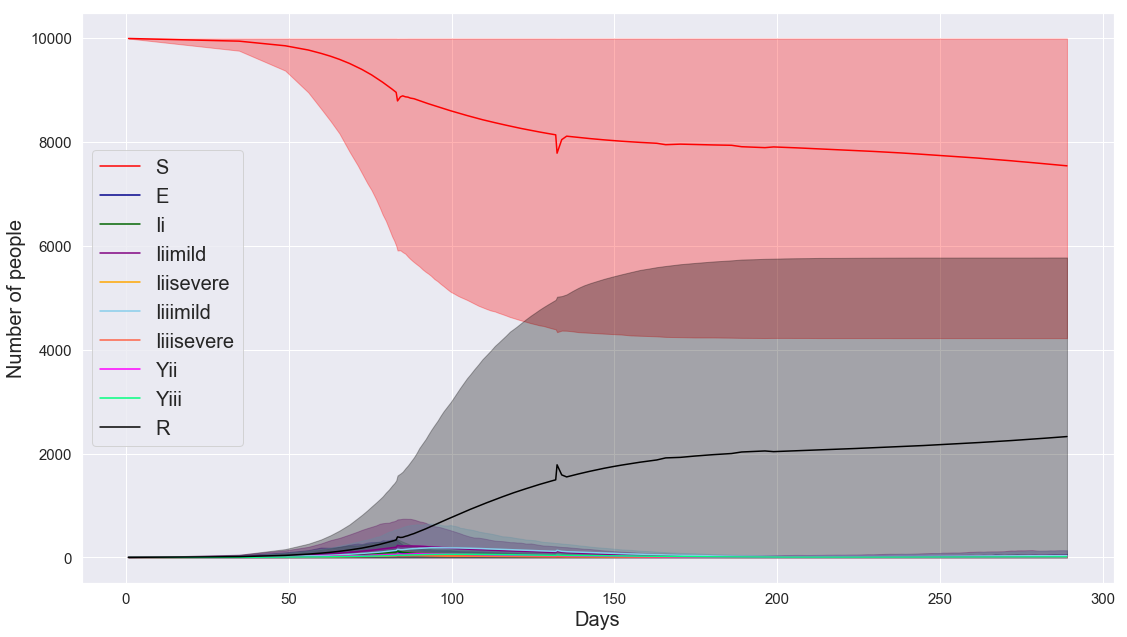

In [7]:
# The number of points to skip per value to make plotting faster
plot_every_n = 100
# Loop over all compartments of the model and plot on the same axes
for lab, col in zip(['S', 'E', 'Ii', 'Iiimild', 'Iiisevere', 'Iiiimild', 'Iiiisevere', 'Yii', 'Yiii', 'R'],
       ['red','darkblue','darkgreen','purple','orange','skyblue','tomato','magenta','springgreen','black']):
    # Compute mean and credible limits
    df = merged_df[[lab+'_'+str(r) for r in range(0,nreals)]]
    df_mean = df.iloc[::plot_every_n, :].mean(axis=1)
    df_lowerCL = df.iloc[::plot_every_n, :].quantile(0.025,axis=1)
    df_upperCL = df.iloc[::plot_every_n, :].quantile(0.975,axis=1)
    # Plot the mean and credible limits in each case
    plt.plot(merged_df.index[::plot_every_n],df_mean.values,color=col,label=lab)
    plt.fill_between(merged_df.index[::plot_every_n],df_lowerCL.values,df_upperCL.values,color=col,alpha=0.3)
# Name axes and rescale plot 
axes = plt.gca()
axes.set_ylabel('Number of people',fontsize=20)
axes.set_xlabel('Days',fontsize=20)
axes.tick_params(labelsize=15)
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.legend(fontsize=20)
plt.show()

...and finally the standard epidemic curve...

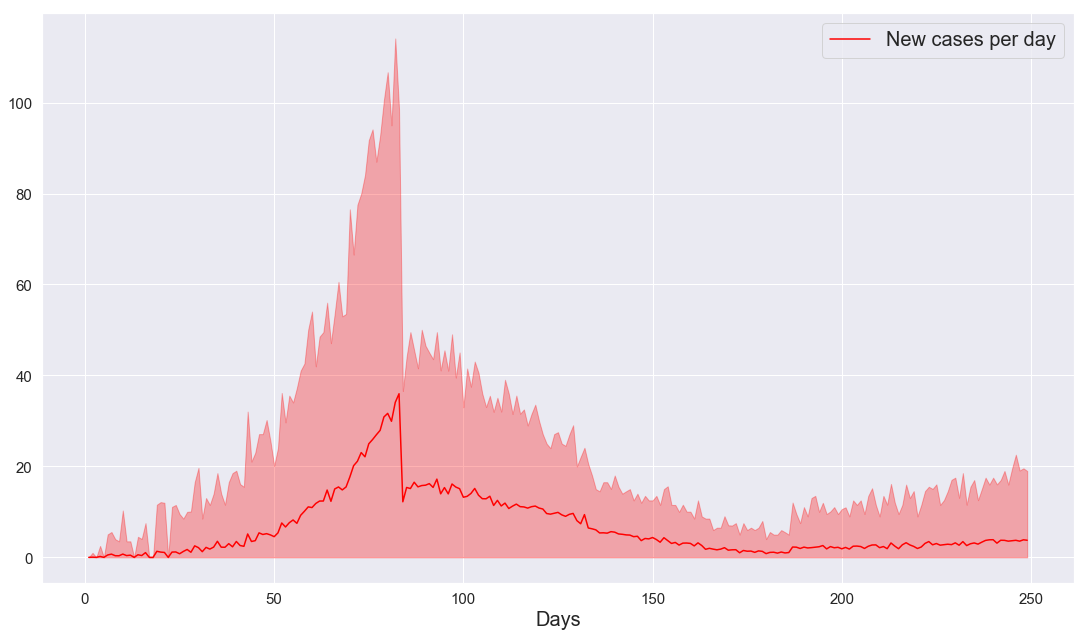

In [8]:
# Obtain the incubating numbers from merged dataframe
E_df = merged_df[['E_'+str(r) for r in range(0,nreals)]]
# New cases per day calculation
DE_df = E_df.diff()
DE_df[DE_df<0.0] = 0.0
ncpd_df = DE_df.groupby(pd.cut(E_df.index, np.arange(0, ndays, 1))).sum()
# Compute mean and credible limits of the effective reproduction number and epidemic growth rate  
ncpd_mean = ncpd_df.mean(axis=1)
ncpd_lowerCL = ncpd_df.quantile(0.025,axis=1)
ncpd_upperCL = ncpd_df.quantile(0.975,axis=1)
# Plot the mean and credible limits in each case
plt.plot(np.arange(1, ndays, 1),ncpd_mean,color='red',label='New cases per day')
plt.fill_between(np.arange(1, ndays, 1),ncpd_lowerCL,ncpd_upperCL,color='red',alpha=0.3)
# Name axes and rescale plot 
axes = plt.gca()
axes.set_xlabel('Days',fontsize=20)
axes.tick_params(labelsize=15)
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.legend(fontsize=20)
plt.show()